# Imports

In [1]:
from collections import Counter
from gensim.models import Word2Vec
from nltk import sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer #for word embedding
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score # bag of words
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import collections
import csv
import gensim
import matplotlib.pyplot as plt
import nltk
import nltk.tokenize
import numpy as np #for text pre-processing
import operator
import pandas as pd
import pathlib
import pickle
import re, string
import seaborn
import string
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')#for model-building
ps = PorterStemmer()

C:\Users\Martin\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\Users\Martin\Anaconda3\lib\site-packages

# Functions

### _1) Reading in files and append them into corpus list_

In [2]:
tok = nltk.tokenize.TreebankWordTokenizer()

def make_corpus(filename):
    corpus = []
    with open(filename, 'r') as f:
        for line in f:
            corpus.extend(t for line in f for t in tok.tokenize(line))
    
    return corpus

### _2) Convert corpus into data frame_

a) voc: counts the total number of tokens in corpus

b) frq_ returns a dataframe with tokens and frequency of each token
    

In [3]:
def dataframe_corpus(corpus):
    voc = collections.Counter(corpus)
    frq = pandas.DataFrame(voc.most_common(), columns=['token', 'frequency'])

    return frq

### _3) Frequency normalized by corpus size and Cumulative normalized frequency inserted into dataframe_

In [4]:
def freq_cum(frq):
    # Index in the sorted list
    frq['idx'] = frq.index + 1

    # Frequency normalised by corpus size
    frq['norm_freq'] = frq.frequency / len(corpus)

    # Cumulative normalised frequency
    frq['cumul_frq'] = frq.norm_freq.cumsum()

    return frq


### _4) Plots for Culumative frequency and Log-log plot for Zipf's law_

In [5]:
seaborn.set(style='whitegrid')

# Plot: Cumulative frequency by index
def freq_cum_plot(frq):
    seaborn.relplot(x='idx', y='cumul_frq', data=frq)
    return plt.show()

# Plot: Cumulative frequency by index, top x tokens
def freq_cum_plot_top_x_tokens(frq, top_x):
    seaborn.relplot(x='idx', y='cumul_frq', data=frq[:int(top_x)], kind='line')
    return plt.show()

# Plot: Log-log plot for Zipf's law
def zipfs_law(frq):
    frq['log_frq'] = numpy.log(frq.frequency)
    frq['log_rank'] = numpy.log(frq.frequency.rank(ascending=True))
    seaborn.relplot(x='log_rank', y='log_frq', data=frq)
    return plt.show()

***

## a.1) Tokenization

In [6]:
def token_sentences(text):
    sentences = sent_tokenize(text)
    return sentences


def tokenization(words,text):
    tokens = word_tokenize(text[1:])
    words = [token.lower() for token in tokens if token.isalpha()]   
    return words

#### a.1.1) Comparing TweetTokenizer with NLTK Tokenizer (Task 1)

In [7]:
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import  word_tokenize

def comparing_tokenizer(text):
    tt = TweetTokenizer()
    tweet_tokenizer = tt.tokenize(text)
    word_tweet_tok = word_tokenize(text)
    return tweet_tokenizer, word_tweet_tok

#output example:

# tweet_tokenizer       = ['#ibelieveblaseyford', 'is', 'liar', 'she', 'is']
# word_tweet_tok (NLTK) = ['#', 'ibelieveblaseyford', 'is', 'liar', 'she']

#### a.1.2) Spacy library

In [8]:
def split_in_sentences(text):
    doc = nlp(text)
    return [str(sent).strip() for sent in doc.sents]

## a.2) Vocabulary 

In [9]:
#converting a dataframe into a single list 
#text is split into words defined by their space inbetween
#words are inserted into list 
def words_list(text):
    #words are inserted into list 
    corpus=[]
    for row in text:
        tokens = row[0].split(" ")
        for token in tokens:
            corpus.append(token)
    
    
    def vocabulary_list(corpus):
        #initlialize the vocabulary
        vocab = list(set(" ".join(corpus)))
        vocab.remove(' ')
        return vocab
      
    
    def split_words_char(corpus):
        #split the word into characters
        corpus = [" ".join(token) for token in corpus]
        #appending </w>
        corpus=[token+' </w>' for token in corpus]
        return corpus
        
    x,y = split_words_char(corpus), vocabulary_list(corpus)
    return x,y


# Creating the Bag of Words model
def bag_of_words(text):
    word2count = {}
    for data in text:
        words = nltk.word_tokenize(data)
        for word in words:  
            if word not in word2count.keys():
                word2count[word] = 1
            else:
                word2count[word] += 1
    return word2count   



## b) Pre-processing and cleaning

In [10]:
# removing punctuations
# convert all words into lower cases
# remove stop words

def preprocess_text(words):
    #delete punctuations
    punctuation_table = str.maketrans('', '', string.punctuation)

    #convert all words into lower cases
    words = [word.translate(punctuation_table).lower() for word in words]
    
    #remove stopwords
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')
    words = [word for word in words if word not in stop_words]

    return words

# cleaning sentences within data frame
def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", elem))  
    return df

def del_punctuations(words):
    punctuation_table = str.maketrans('', '', string.punctuation)
    words = [word.translate(punctuation_table).lower() for word in words]
    return words


def stop_words(words):
    stop_words = stopwords.words('english')
    words = [word for word in words if word not in stop_words]
    return words

def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text


## c) Basic statistics

In [11]:
# number of tokens, sentences, average tokens, total unique tokens, total number of tokens after cleaning

def basic_statistics(text,printer = False):
    sents = nltk.sent_tokenize(text)
    tokens = word_tokenize(text[1:])
    words = [token.lower() for token in tokens if token.isalpha()]
    average_tokens = round(len(words)/len(sents))
    unique_tokens = set(words)
    token_ratio = round(len(unique_tokens)/len(tokens),3)
    stop_words = set(stopwords.words('english'))
    final_tokens = []
    for each in words:
        if each not in stop_words:
            final_tokens.append(each)
    if printer == True:
        print(f'The number of characters: {len(text)}')
        print(f'The number of tokens is: {len(tokens)}')
        print(f'The number of sentences is: {len(sents)}')
        print(f'The average number of tokens per sentence is: {average_tokens}')
        print(f'The number of unique tokens are: {len(unique_tokens)}')
        print(f'The tokens ratio is: {token_ratio}')
        print(f'The number of total tokens after removing stopwords are: {len(final_tokens)}')
    return len(text), len(tokens), len(sents), average_tokens, len(unique_tokens), token_ratio, len(final_tokens)

def word_frequency(words):
    frequency_words = collections.Counter(words)
    
    #convert counter object to dictionary
    frequency_words_dict = dict(frequency_words)
    res = dict(sorted(frequency_words_dict.items(), key=lambda item: item[1]))
    return res

def top_20_most_common_words(freq_words):
    res = dict(Counter(freq_words).most_common(20))
    return res

def most_common_words(dictionary):
    # Output a dict of most common words
    return dict(sorted(dictionary.items(),key=lambda x: x[1], reverse=True))

def least_common_words(dictionary):
    return sorted(list(dictionary.items()),key=lambda x: x[1])


# Function for loglog plots
def llplot(list_var, labels, title):
    """Function that takes a list of datasets, list of labels and a title as string, and plots a loglogplot, example:
    llplot([offensive_freq_words_val, offensive_freq_words_train, offensive_freq_words_test], ["val", "train", "test"], "Offensive dataset, loglog plot")
    """
    # Size of the figure:
    plt.figure(figsize = (7,6))
    # Iterating through the datasets:
    for idx, i in enumerate(list_var):
        y = np.log(list(most_common_words(i).values()))
        x = np.log([i for i in range(1,len(y)+1)])
        plt.scatter(x, y, label = labels[idx])
    # Labeling title and axis:
    plt.title(title)
    plt.xlabel("Rank of word")
    plt.ylabel("Frequency of word")
    # Plotting:
    plt.legend()
    plt.show()
    return None


## Spacy - preprocessing/cleaning

In [12]:
def merging_labels_and_sentences(textfile, labelfile):

    # read textfile and labelfile into two separate dataframes
    df_text = pd.read_csv(textfile + '.txt', header=None, skiprows = 0,
        names=['tweet'], sep='\t', quoting=3)
    df_labels = pd.read_csv(labelfile + '.txt',header=None, skiprows = 0, names=['label'],
        sep='\t', quoting=3)

    index_text = [x for x in range(1, len(df_text.values)+1)]

    df_labels.insert(loc=0, column='id', value =index_text)
    df_text.insert(loc=0, column='id', value =index_text)
    final_df = df_text.merge(df_labels, on='id', how='left')

    return final_df

def class_distribution(dataframe,title,xlabel_title):
    x = dataframe['label'].value_counts()
    barplot = seaborn.barplot(x.index, x)
    barplot.set_title(title)
    barplot.set_xlabel(xlabel_title)
    barplot.set_ylabel("Count")
    return barplot

# WORD-COUNT
def word_count(dataframe_col):
    dataframe_col['word_count'] = dataframe_col['tweet'].apply(lambda x: len(str(x).split()))
    
    avg_off_tweets = round(dataframe_col[dataframe_col['label']==1]['word_count'].mean(),3)
    avg_non_off_tweets = round(dataframe_col[dataframe_col['label']==0]['word_count'].mean(),3) 

    return dataframe_col, avg_off_tweets, avg_non_off_tweets

# CHARACTER-COUNT
def char_count(dataframe_col):
    dataframe_col['char_count'] = dataframe_col['tweet'].apply(lambda x: len(str(x)))
    
    #the average characters in offensive tweets
    avg_char_off = round(dataframe_col[dataframe_col['label']==1]['char_count'].mean(),3) 

    #the average characters in non-offensive tweets
    avg_char_non_off = round(dataframe_col[dataframe_col['label']==0]['char_count'].mean(),3)

    return dataframe_col, avg_char_off, avg_char_non_off

def plot_word_count(dataframe):
    # PLOTTING WORD-COUNT
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
    dataframe_words=dataframe[dataframe['label']==1]['word_count']
    ax1.hist(dataframe_words,color='red')
    ax1.set_title('offensive tweets')
    dataframe_words=dataframe[dataframe['label']==0]['word_count']
    ax2.hist(dataframe_words,color='green')
    ax2.set_title('non-offensive tweets')
    fig.suptitle('Words per tweet')
    ax2.set_xlabel("Length of tweet")
    ax2.set_ylabel("occurrences")
    ax1.set_xlabel("Length of tweet")
    ax1.set_ylabel("occurrences")
    plt.show()

def missing_values(dataframe):
    res = dataframe.isna().sum()
    return res

#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text
 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)
    
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))



## D) Classification

In [13]:
#SPLITTING THE VALIDATION DATASET INTO TRAIN AND TEST


def split_dataset(dataframe):
    X_train, X_test, y_train, y_test = train_test_split(dataframe["tweet"],dataframe      
    ["label"],test_size=0.2,shuffle=True)
    return X_train, X_test, y_train, y_test
    
def tokenize_train_test(X_train, X_test):
    #Word2Vec
    # Word2Vec runs on tokenized sentences
    X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
    X_test_tok= [nltk.word_tokenize(i) for i in X_test]

    return X_train_tok, X_test_tok


#building Word2Vec model
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([np.mean([self.word2vec[w] 
        for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0) 
        for words in X])

#building Word2Vec model
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([np.mean([self.word2vec[w] 
        for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0) 
        for words in X])

## Model prediction

#### Cleaned

In [14]:
def model_prediction_preprocessed_data(dataframe):
    #Pre-processing the new dataset
    dataframe['clean_text'] = dataframe['tweet'].apply(lambda x: finalpreprocess(x)) 
    
    #preprocess the data
    X_test=dataframe['clean_text'] 

    #converting words to numerical data using tf-idf
    X_vector=tfidf_vectorizer.transform(X_test)

    #use the best model to predict 'target' value for the new dataset 
    y_predict = lr_tfidf.predict(X_vector)      
    y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
    dataframe['predict_prob']= y_prob
    dataframe['label']= y_predict
    final=dataframe[['clean_text','label']].reset_index(drop=True)
    return final 


#### Non cleaned

In [15]:
def model_prediction_nonprocessed_data(dataframe):
    X_test=dataframe['tweet'] 

    #converting words to numerical data using tf-idf
    X_vector=tfidf_vectorizer.transform(X_test)

    #use the best model to predict 'target' value for the new dataset 
    y_predict = lr_tfidf.predict(X_vector)      
    y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
    dataframe['predict_prob']= y_prob
    dataframe['label']= y_predict
    final=dataframe[['tweet','label']].reset_index(drop=True)
    return final 


***
***

# TASK 1: PRE-PROCESSING AND TOKENIZATION
_ splitting text files into words _


## 1.1) Text file: Emoji
***

### Read in txt files: offensive/emoji.txt

In [16]:
file_path_val = pathlib.Path(r'datasets/emoji/val_text.txt')

with open(file_path_val, 'r',encoding="utf8") as f:
    emoji_text_val = f.read()       
    f.close()
    
emoji_words_val_txt = emoji_text_val[1:].split()

print(emoji_words_val_txt[:100])

['little', 'throwback', 'with', 'my', 'favourite', 'person', '@', 'Water', 'Wall', 'glam', 'on', '@user', 'yesterday', 'for', '#kcon', 'makeup', 'using', '@user', 'in', '#featherette,…', 'Democracy', 'Plaza', 'in', 'the', 'wake', 'of', 'a', 'stunning', 'outcome', '#Decision2016', '@', 'NBC', 'News', 'Then', '&amp;', 'Now.', 'VILO', '@', 'Walt', 'Disney', 'Magic', 'Kingdom', 'Who', 'never...', '@', 'A', 'Galaxy', 'Far', 'Far', 'Away', 'Dinner', 'in', 'FLA', 'tonight', '//', 'Pan-seared', 'salmon', 'over', 'couscous', 'veggie', 'salad', '#yum', '#dinner', '#florida', '#salmon…', "It's", 'my', 'fav', 'seniors', 'last', 'game', 'congrats', 'on', 'beating', 'west', '@', 'West', 'Salem…', 'I', 'got', 'to', 'to', 'go', 'formal', 'with', 'my', 'best', 'friend', '@', 'Phi', 'Mu', 'at', 'JSU', "'Cause", 'I', 'Miss', 'My', 'Little', 'Homies', '.#Throwback']


In [17]:
file_path_train = pathlib.Path(r'datasets/emoji/train_text.txt')


with open(file_path_train, 'r',encoding="utf8") as f:
    emoji_text_train = f.read()       
    f.close()
    
emoji_words_train_txt = emoji_text_train[1:].split()
print(emoji_words_train_txt[:100])

['unday', 'afternoon', 'walking', 'through', 'Venice', 'in', 'the', 'sun', 'with', '@user', '️', '️', '️', '@', 'Abbot', 'Kinney,', 'Venice', 'Time', 'for', 'some', 'BBQ', 'and', 'whiskey', 'libations.', 'Chomp,', 'belch,', 'chomp!', '(@', "Lucille's", 'Smokehouse', 'Bar-B-Que)', 'Love', 'love', 'love', 'all', 'these', 'people', '️', '️', '️', '#friends', '#bff', '#celebrate', '#blessed', '#sundayfunday', '@', 'San…', '️', '️', '️', '️', '@', 'Toys"R"Us', 'Man', 'these', 'are', 'the', 'funniest', 'kids', 'ever!!', 'That', 'face!', '#HappyBirthdayBubb', '@', 'FLIPnOUT', 'Xtreme', '#sandiego', '@', 'San', 'Diego,', 'California', 'My', 'little', '️', '️', '️', '️', '️', '#ObsessedWithMyDog', '@', 'Cafe', 'Solstice', 'Capitol', 'Hill', 'More', '#tinyepic', 'things', '#tinyepicwestern,', 'this', 'one', 'is', 'crazy', '@user', 'I', 'may', 'be', 'one', 'of', 'your…', 'Last']


In [18]:
file_path_test = pathlib.Path(r'datasets/emoji/test_text.txt')


with open(file_path_test, 'r',encoding="utf8") as f:
    emoji_text_test = f.read()       
    f.close()
    
emoji_words_test_txt = emoji_text_test[1:].split()
print(emoji_words_test_txt[:100])

['n', 'Pelham', 'Parkway', 'The', 'calm', 'before......', '|', 'w/', 'sofarsounds', '@user', '|', ':', 'B.', 'Hall.......#sofarsounds…', 'Just', 'witnessed', 'the', 'great', 'solar', 'eclipse', '@', 'Tampa,', 'Florida', 'This', 'little', 'lady', 'is', '26', 'weeks', 'pregnant', 'today!', 'Excited', 'for', 'baby', 'Cam', 'to', 'come!', '@', 'Springfield,…', 'Great', 'road', 'trip', 'views!', '@', 'Shartlesville,', 'Pennsylvania', 'CHRISTMAS', 'DEALS', 'BUY', 'ANY', '3', 'SMALL', 'POMADES', '1.5', 'OR', '1.7', 'OZ', 'RECEIVE', 'THE', 'F&amp;S', 'COLLECTOR', 'TIN', '&amp;', 'COMB…', 'the', '#sisterstunt', 'was', 'mad', 'real', 'last', 'night', '#MiaStaxxx', '#AndreaStaxxx', '#denverqueen', '#staxxxlife…', "I'm", 'starting', 'to', 'love', 'shooting', 'in', 'the', 'dark', '#brandonwolfel', '@', 'New', 'York,', 'New', 'York', 'Let', 'the', 'sun', 'shine', 'through', '️', '5x5', 'Feet', '#oilpainting', '#oiloncanvas', '#acrylicpainting']


### Remove punctuations from txt files
_ meaning signs, spacing and other disturbing features. Alle words are then turned into lower cases_

In [19]:


emoji_cleaned_val_words = del_punctuations(emoji_words_val_txt)
emoji_cleaned_train_words = del_punctuations(emoji_words_train_txt)
emoji_cleaned_test_words = del_punctuations(emoji_words_test_txt)

print('val_text.txt:\n',emoji_cleaned_val_words[:100],'\n')

print('\nval_train.txt:\n',emoji_cleaned_train_words[:100], '\n')

print('\nval_test.txt:\n',emoji_cleaned_test_words[:100],'\n')

val_text.txt:
 ['little', 'throwback', 'with', 'my', 'favourite', 'person', '', 'water', 'wall', 'glam', 'on', 'user', 'yesterday', 'for', 'kcon', 'makeup', 'using', 'user', 'in', 'featherette…', 'democracy', 'plaza', 'in', 'the', 'wake', 'of', 'a', 'stunning', 'outcome', 'decision2016', '', 'nbc', 'news', 'then', 'amp', 'now', 'vilo', '', 'walt', 'disney', 'magic', 'kingdom', 'who', 'never', '', 'a', 'galaxy', 'far', 'far', 'away', 'dinner', 'in', 'fla', 'tonight', '', 'panseared', 'salmon', 'over', 'couscous', 'veggie', 'salad', 'yum', 'dinner', 'florida', 'salmon…', 'its', 'my', 'fav', 'seniors', 'last', 'game', 'congrats', 'on', 'beating', 'west', '', 'west', 'salem…', 'i', 'got', 'to', 'to', 'go', 'formal', 'with', 'my', 'best', 'friend', '', 'phi', 'mu', 'at', 'jsu', 'cause', 'i', 'miss', 'my', 'little', 'homies', 'throwback'] 


val_train.txt:
 ['unday', 'afternoon', 'walking', 'through', 'venice', 'in', 'the', 'sun', 'with', 'user', '️', '️', '️', '', 'abbot', 'kinney', 'venice

In [20]:

#nltk.download('punkt')

emoji_sentences_val_txt = token_sentences(emoji_text_val)   
emoji_sentences_train_txt = token_sentences(emoji_text_train)
emoji_sentences_test_txt = token_sentences(emoji_text_test)   

print(emoji_sentences_val_txt[:5])
print(emoji_sentences_train_txt[:5])
print(emoji_sentences_test_txt[:5])

['A little throwback with my favourite person @ Water Wall\nglam on @user yesterday for #kcon makeup using @user in #featherette,…\nDemocracy Plaza in the wake of a stunning outcome #Decision2016 @ NBC News\nThen &amp; Now.', "VILO @ Walt Disney Magic Kingdom\nWho never... @ A Galaxy Far Far Away\nDinner in FLA tonight // Pan-seared salmon over couscous veggie salad #yum #dinner #florida #salmon…\nIt's my fav seniors last game congrats on beating west @ West Salem…\nI got to to go formal with my best friend @ Phi Mu at JSU\n'Cause I Miss My Little Homies .#Throwback #CousinLove @ Indiana University\nBirthday Kisses @ Madison, Wisconsin\nGreat time in Tuscaloosa with my girl!", '@ Bryant–Denny Stadium\nA seguir aprendiendo del mundo de las berries (@ John F. Kennedy International Airport (JFK) in Queens, NY, NY)\n#livinginparadise @ Ramada Plaza Beach Resort\n••In order for your life to be "GREAT" you must first learn to "APPRECIATE" it... •• #Ny…\nThese girls!', '#seniors2016 #memories

### Number of words in each tokenization variables

In [21]:

emoji_token_val = tokenization(emoji_cleaned_val_words, emoji_text_val)
emoji_token_train = tokenization(emoji_cleaned_train_words, emoji_text_train)
emoji_token_test = tokenization(emoji_cleaned_test_words, emoji_text_test)

print(f'Number of words in tokenization for val_text: {len(emoji_token_val)}')
print(f'Number of words in tokenization for val_train: {len(emoji_token_train)}')
print(f'Number of words in tokenization for val_test: {len(emoji_token_test)}')

Number of words in tokenization for val_text: 49591
Number of words in tokenization for val_train: 460902
Number of words in tokenization for val_test: 517054


### Removing stopwords like 'and, or, of, is, had.... etc' 

In [22]:
emoji_cleaned_val_words = stop_words(emoji_token_val)
emoji_cleaned_train_words = stop_words(emoji_token_train)
emoji_cleaned_test_words = stop_words(emoji_token_test)

print(f'Number of words after removing Stop Words: {len(emoji_cleaned_val_words)}')
print(f'Number of words after removing Stop Words: {len(emoji_cleaned_train_words)}')
print(f'Number of words after removing Stop Words: {len(emoji_cleaned_test_words)}')


Number of words after removing Stop Words: 33580
Number of words after removing Stop Words: 314127
Number of words after removing Stop Words: 345189


### Frequency of each word

In [23]:
import collections

#returns frequency of each word
emoji_freq_words_val = word_frequency(emoji_cleaned_val_words)
emoji_freq_words_train = word_frequency(emoji_cleaned_train_words)
emoji_freq_words_test = word_frequency(emoji_cleaned_test_words)


print('_'*112,'\n')
print('Frequency of words in val_text:\n',list(emoji_freq_words_val.items())[-40:-1], '\n')
print('_'*112,'\n')
print('Frequency of words in train_text:\n',list(emoji_freq_words_train.items())[-40:-1], '\n')
print('_'*112,'\n')
print('Frequency of words in test_text:\n',list(emoji_freq_words_test.items())[-40:-1], '\n')
print('_'*112,'\n')

________________________________________________________________________________________________________________ 

Frequency of words in val_text:
 [('friends', 76), ('high', 76), ('much', 78), ('fun', 78), ('first', 79), ('school', 81), ('life', 82), ('thank', 82), ('thanks', 86), ('center', 87), ('california', 87), ('see', 87), ('get', 89), ('city', 91), ('great', 96), ('back', 96), ('ca', 98), ('little', 99), ('university', 103), ('beautiful', 106), ('christmas', 116), ('like', 118), ('birthday', 119), ('last', 120), ('one', 125), ('today', 133), ('best', 136), ('got', 137), ('time', 137), ('good', 137), ('beach', 147), ('york', 148), ('night', 151), ('park', 152), ('day', 223), ('happy', 225), ('amp', 245), ('new', 292), ('love', 389)] 

________________________________________________________________________________________________________________ 

Frequency of words in train_text:
 [('city', 736), ('francisco', 746), ('great', 751), ('fun', 756), ('little', 778), ('see', 783), (

### Vocabulary list for offensive text files
_Looking through vocabulary lists can help you find problems
(especially tokens that only occur once or twice)._

In [24]:


emoji_corpus_val, emoji_vocab_val = words_list(emoji_text_val)
emoji_corpus_train, emoji_vocab_train = words_list(emoji_text_train)
emoji_corpus_test, emoji_vocab_test = words_list(emoji_text_test)

print('Vocabulary for text_val.txt:\n', emoji_vocab_val[:20],'\n')
print('Vocabulary for text_train.txt:\n', emoji_vocab_train[:20],'\n')
print('Vocabulary for text_test.txt:\n', emoji_vocab_test[:20],'\n')

Vocabulary for text_val.txt:
 ['ｓ', '&', 'c', 'u', 'ｉ', '♾', 'l', '⠀', '_', 'T', '+', '{', 'O', 'イ', 'd', '6', '⃣', 'ロ', 'ブ', 'ｔ'] 

Vocabulary for text_train.txt:
 ['Ｏ', 'ᴴ', 'ป', 'し', '미', '◈', '͟', 'ᴰ', 'O', 'ˈ', '่', '✥', '·', '6', '卦', '챗', 'ロ', '🇺', 'í', '楽'] 

Vocabulary for text_test.txt:
 ['᠌', '♾', '☻', 'ᴴ', 'し', 'Ｅ', 'ᴰ', 'O', '่', 'ˈ', '·', '6', 'ロ', '🇺', '世', 'í', '楽', '場', 'ท', 'ｔ'] 



### Read in txt files: offensive/val_text.txt

In [25]:
#offensive_

In [26]:
file_path_val = pathlib.Path(r'datasets/offensive/val_text.txt')

with open(file_path_val, 'r',encoding="utf8") as f:
    offensive_text_val = f.read()       
    f.close()
    
offensive_words_val_txt = offensive_text_val[1:].split()

print(offensive_words_val_txt[:100])

['user', '@user', 'WiiU', 'is', 'not', 'even', 'a', 'real', 'console.', '@user', '@user', '@user', 'If', 'he', 'is', 'from', 'AZ', 'I', 'would', 'put', 'my', 'money', 'on', 'sex', 'with', 'underage', 'kids.', '@user', 'I', 'thought', 'Canada', 'had', 'strict', 'gun', 'control.', 'Help', 'me', 'understand', 'what', 'is', 'happening.', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', 'Following', 'all', '#Maga', 'patriots', 'please', 'follow', 'back', '👍', '#LionsDen', '🦁', '#MAGA2KAG', '🇺🇸', '1', 'Minute', 'of', 'Truth:', 'Gun', 'Control', 'via', '@user', '@user', '@user', '@user', 'We', 'could', 'help', 'if', 'you', 'are', 'London', 'based', '😊', '@user', '@user', 'There', 'r', '65', 'million', 'that', 'can', 'sign', 'to', 'the']


In [27]:
file_path_train = pathlib.Path(r'datasets/offensive/train_text.txt')


with open(file_path_train, 'r',encoding="utf8") as f:
    offensive_text_train = f.read()       
    f.close()
    
offensive_words_train_txt = offensive_text_train[1:].split()
print(offensive_words_train_txt[:100])

['user', 'Bono...', 'who', 'cares.', 'Soon', 'people', 'will', 'understand', 'that', 'they', 'gain', 'nothing', 'from', 'following', 'a', 'phony', 'celebrity.', 'Become', 'a', 'Leader', 'of', 'your', 'people', 'instead', 'or', 'help', 'and', 'support', 'your', 'fellow', 'countrymen.', '@user', 'Eight', 'years', 'the', 'republicans', 'denied', 'obama’s', 'picks.', 'Breitbarters', 'outrage', 'is', 'as', 'phony', 'as', 'their', 'fake', 'president.', '@user', 'Get', 'him', 'some', 'line', 'help.', 'He', 'is', 'gonna', 'be', 'just', 'fine.', 'As', 'the', 'game', 'went', 'on', 'you', 'could', 'see', 'him', 'progressing', 'more', 'with', 'his', 'reads.', 'He', 'brought', 'what', 'has', 'been', 'missing.', 'The', 'deep', 'ball', 'presence.', 'Now', 'he', 'just', 'needs', 'a', 'little', 'more', 'time', '@user', '@user', 'She', 'is', 'great.', 'Hi', 'Fiona!', '@user']


In [28]:
file_path_test = pathlib.Path(r'datasets/offensive/test_text.txt')


with open(file_path_test, 'r',encoding="utf8") as f:
    offensive_text_test = f.read()       
    f.close()
    
offensive_words_test_txt = offensive_text_test[1:].split()
print(offensive_words_test_txt[:100])

['ibelieveblaseyford', 'is', 'liar', 'she', 'is', 'fat', 'ugly', 'libreal', '#snowflake', 'she', 'sold', 'her', 'herself', 'to', 'get', 'some', 'cash', '!!', 'From', 'dems', 'and', 'Iran', '!', 'Why', 'she', 'spoke', 'after', '#JohnKerryIranMeeting', '?', '@user', '@user', '@user', 'I', 'got', 'in', 'a', 'pretty', 'deep', 'debate', 'with', 'my', 'friend', 'and', 'she', 'told', 'me', 'that', 'latinos', 'for', 'Trump', 'and', 'blacks', 'for', 'Trump', 'were', 'paid', 'supporters', '😂', 'then', 'I', 'said', 'you', 'mean', 'antifa', 'are', 'paid', 'domestic', 'terrorist', 'and', 'she', 'said', 'No', 'they', 'are', 'anti-fascist', 'then', 'I', 'said', 'they', 'are', 'the', 'fascist', 'are', 'you', 'kidding', 'me?!', '...if', 'you', 'want', 'more', 'shootings', 'and', 'more', 'death,', 'then', 'listen', 'to', 'the', 'ACLU,', 'Black']


### Remove punctuations from txt files
_ meaning signs, spacing and other disturbing features. Alle words are then turned into lower cases_

In [29]:

offensive_cleaned_val_words = del_punctuations(offensive_words_val_txt)
offensive_cleaned_train_words = del_punctuations(offensive_words_train_txt)
offensive_cleaned_test_words = del_punctuations(offensive_words_test_txt)

print('val_text.txt:\n',offensive_cleaned_val_words[:100],'\n')

print('\nval_train.txt:\n',offensive_cleaned_train_words[:100], '\n')

print('\nval_test.txt:\n',offensive_cleaned_test_words[:100],'\n')

val_text.txt:
 ['user', 'user', 'wiiu', 'is', 'not', 'even', 'a', 'real', 'console', 'user', 'user', 'user', 'if', 'he', 'is', 'from', 'az', 'i', 'would', 'put', 'my', 'money', 'on', 'sex', 'with', 'underage', 'kids', 'user', 'i', 'thought', 'canada', 'had', 'strict', 'gun', 'control', 'help', 'me', 'understand', 'what', 'is', 'happening', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'following', 'all', 'maga', 'patriots', 'please', 'follow', 'back', '👍', 'lionsden', '🦁', 'maga2kag', '🇺🇸', '1', 'minute', 'of', 'truth', 'gun', 'control', 'via', 'user', 'user', 'user', 'user', 'we', 'could', 'help', 'if', 'you', 'are', 'london', 'based', '😊', 'user', 'user', 'there', 'r', '65', 'million', 'that', 'can', 'sign', 'to', 'the'] 


val_train.txt:
 ['user', 'bono', 'who', 'cares', 'soon', 'people', 'will', 'understand', 'that', 'they', 'gain', 'nothing', 'from', 'following', 'a', 'phony', 'celebrity', 'become', 

### Number of words in each tokenization variables

In [30]:
from nltk.tokenize import word_tokenize


offensive_token_val = tokenization(offensive_cleaned_val_words, offensive_text_val)
offensive_token_train = tokenization(offensive_cleaned_train_words, offensive_text_train)
offensive_token_test = tokenization(offensive_cleaned_test_words, offensive_text_test)

print(f'Number of words in tokenization for val_text: {len(offensive_token_val)}')
print(f'Number of words in tokenization for val_train: {len(offensive_token_train)}')
print(f'Number of words in tokenization for val_test: {len(offensive_token_test)}')

Number of words in tokenization for val_text: 30416
Number of words in tokenization for val_train: 258224
Number of words in tokenization for val_test: 19619


### Removing stopwords like 'and, or, of, is, had.... etc' 

In [31]:
from nltk.corpus import stopwords


offensive_cleaned_val_words = stop_words(offensive_token_val)
offensive_cleaned_train_words = stop_words(offensive_token_train)
offensive_cleaned_test_words = stop_words(offensive_token_test)

print(f'Number of words after removing Stop Words: {len(offensive_cleaned_val_words)}')
print(f'Number of words after removing Stop Words: {len(offensive_cleaned_train_words)}')
print(f'Number of words after removing Stop Words: {len(offensive_cleaned_test_words)}')


Number of words after removing Stop Words: 17155
Number of words after removing Stop Words: 147302
Number of words after removing Stop Words: 11080


### Frequency of each word

In [32]:
import collections

#returns frequency of each word
offensive_freq_words_val = word_frequency(offensive_cleaned_val_words)
offensive_freq_words_train = word_frequency(offensive_cleaned_train_words)
offensive_freq_words_test = word_frequency(offensive_cleaned_test_words)


print('_'*112,'\n')
print('Frequency of words in val_text:\n',list(offensive_freq_words_val.items())[-40:-1], '\n')
print('_'*112,'\n')
print('Frequency of words in train_text:\n',list(offensive_freq_words_train.items())[-40:-1], '\n')
print('_'*112,'\n')
print('Frequency of words in test_text:\n',list(offensive_freq_words_test.items())[-40:-1], '\n')
print('_'*112,'\n')

________________________________________________________________________________________________________________ 

Frequency of words in val_text:
 [('love', 31), ('great', 31), ('much', 32), ('democrats', 32), ('country', 32), ('could', 33), ('vote', 33), ('shit', 33), ('never', 35), ('believe', 35), ('way', 35), ('need', 36), ('say', 37), ('still', 38), ('time', 40), ('make', 40), ('go', 41), ('good', 42), ('even', 43), ('see', 44), ('right', 45), ('going', 47), ('us', 52), ('want', 55), ('would', 61), ('amp', 62), ('think', 68), ('trump', 69), ('one', 71), ('get', 73), ('know', 77), ('people', 89), ('maga', 98), ('conservatives', 107), ('like', 109), ('antifa', 118), ('control', 125), ('gun', 133), ('liberals', 137)] 

________________________________________________________________________________________________________________ 

Frequency of words in train_text:
 [('better', 237), ('vote', 237), ('well', 240), ('much', 249), ('left', 252), ('still', 262), ('make', 276), ('way', 2

# My approach to task 1

In [33]:
#This is the ideal tokenization from the library we were supposed to compare it with
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

sentence = 'Heroin is my passion.'

tknzr.tokenize(sentence)

['Heroin', 'is', 'my', 'passion', '.']

In [34]:
#Recreate
import re
import pathlib

file_path_train = pathlib.Path(r'datasets/offensive/train_text.txt')

token_pattern = re.compile(r'\w+')

with open(file_path_train, 'r',encoding="utf8") as f:
    line = f.readline()
    tokens = []
    while line:
        line = f.readline()
        print(line)
        print("OUR beta tokenizer",re.findall(token_pattern,line))
        print("DESIRED  tokenizer",tknzr.tokenize(line))
        print('\n')
    

@user Eight years the republicans denied obama’s picks. Breitbarters outrage is as phony as their fake president. 

OUR beta tokenizer ['user', 'Eight', 'years', 'the', 'republicans', 'denied', 'obama', 's', 'picks', 'Breitbarters', 'outrage', 'is', 'as', 'phony', 'as', 'their', 'fake', 'president']
DESIRED  tokenizer ['@user', 'Eight', 'years', 'the', 'republicans', 'denied', 'obama', '’', 's', 'picks', '.', 'Breitbarters', 'outrage', 'is', 'as', 'phony', 'as', 'their', 'fake', 'president', '.']


@user Get him some line help. He is gonna be just fine. As the game went on you could see him progressing more with his reads. He brought what has been missing. The deep ball presence. Now he just needs a little more time 

OUR beta tokenizer ['user', 'Get', 'him', 'some', 'line', 'help', 'He', 'is', 'gonna', 'be', 'just', 'fine', 'As', 'the', 'game', 'went', 'on', 'you', 'could', 'see', 'him', 'progressing', 'more', 'with', 'his', 'reads', 'He', 'brought', 'what', 'has', 'been', 'missing', 

DESIRED  tokenizer ['@user', '@user', 'Silly', 'Joe', '!', 'I', '’', 'm', 'a', 'MAGA', 'Of', 'Society', '💯', '🇺', '🇸', '❤', '️', '🇺', '🇸', '❤', '️', '🇺', '🇸', '...', 'Feel', 'That', '👊', '👊']


@user @user The Gibraltar people will be hostages in the remaining #Brexit negotiations. Do @user or the @user care? Not a fig! 

OUR beta tokenizer ['user', 'user', 'The', 'Gibraltar', 'people', 'will', 'be', 'hostages', 'in', 'the', 'remaining', 'Brexit', 'negotiations', 'Do', 'user', 'or', 'the', 'user', 'care', 'Not', 'a', 'fig']
DESIRED  tokenizer ['@user', '@user', 'The', 'Gibraltar', 'people', 'will', 'be', 'hostages', 'in', 'the', 'remaining', '#Brexit', 'negotiations', '.', 'Do', '@user', 'or', 'the', '@user', 'care', '?', 'Not', 'a', 'fig', '!']


@user @user Pushed to my limits. 

OUR beta tokenizer ['user', 'user', 'Pushed', 'to', 'my', 'limits']
DESIRED  tokenizer ['@user', '@user', 'Pushed', 'to', 'my', 'limits', '.']


@user It's the ANTIFA gang! 

OUR beta tokenizer ['user', 'It'


@user @user Kind of why we need NATION-WIDE GUN CONTROL. Are you really that stupid? 

OUR beta tokenizer ['user', 'user', 'Kind', 'of', 'why', 'we', 'need', 'NATION', 'WIDE', 'GUN', 'CONTROL', 'Are', 'you', 'really', 'that', 'stupid']
DESIRED  tokenizer ['@user', '@user', 'Kind', 'of', 'why', 'we', 'need', 'NATION-WIDE', 'GUN', 'CONTROL', '.', 'Are', 'you', 'really', 'that', 'stupid', '?']


@user @user It's too had liberals are exempt from laws. 

OUR beta tokenizer ['user', 'user', 'It', 's', 'too', 'had', 'liberals', 'are', 'exempt', 'from', 'laws']
DESIRED  tokenizer ['@user', '@user', "It's", 'too', 'had', 'liberals', 'are', 'exempt', 'from', 'laws', '.']


@user @user And what if she is lying? What if Kavanaugh is the victim of a smear and character assassination? What then? 

OUR beta tokenizer ['user', 'user', 'And', 'what', 'if', 'she', 'is', 'lying', 'What', 'if', 'Kavanaugh', 'is', 'the', 'victim', 'of', 'a', 'smear', 'and', 'character', 'assassination', 'What', 'then']
DE

DESIRED  tokenizer ['@user', 'Oh', 'I', 'love', 'this', 'so', 'much', 'and', 'had', 'no', 'idea', 'your', 'daughter', 'and', 'family', 'had', 'been', 'through', 'the', 'struggle', 'of', 'childhood', 'leukemia', '.', 'So', 'happy', 'to', 'hear', 'she', 'is', 'a', 'healthy', 'strong', 'college', 'athlete', '!', 'Much', 'love', 'to', 'you', 'and', 'yours', '...', '❤', '️', '💪', '🏻', '❤', '️']


MAGA Mike Mack has the funniest tweet ever. I know he's  pissed but it's funny #jonesout 

OUR beta tokenizer ['MAGA', 'Mike', 'Mack', 'has', 'the', 'funniest', 'tweet', 'ever', 'I', 'know', 'he', 's', 'pissed', 'but', 'it', 's', 'funny', 'jonesout']
DESIRED  tokenizer ['MAGA', 'Mike', 'Mack', 'has', 'the', 'funniest', 'tweet', 'ever', '.', 'I', 'know', "he's", 'pissed', 'but', "it's", 'funny', '#jonesout']


People are sick of books from crooks.   #MAGA #RedWaveRising 

OUR beta tokenizer ['People', 'are', 'sick', 'of', 'books', 'from', 'crooks', 'MAGA', 'RedWaveRising']
DESIRED  tokenizer ['Peopl

@user @user You are way off 

OUR beta tokenizer ['user', 'user', 'You', 'are', 'way', 'off']
DESIRED  tokenizer ['@user', '@user', 'You', 'are', 'way', 'off']


@user @user Cause gun control worked so well for chicago? 

OUR beta tokenizer ['user', 'user', 'Cause', 'gun', 'control', 'worked', 'so', 'well', 'for', 'chicago']
DESIRED  tokenizer ['@user', '@user', 'Cause', 'gun', 'control', 'worked', 'so', 'well', 'for', 'chicago', '?']


@user @user You are whoring yourself out for NRA $$! 

OUR beta tokenizer ['user', 'user', 'You', 'are', 'whoring', 'yourself', 'out', 'for', 'NRA']
DESIRED  tokenizer ['@user', '@user', 'You', 'are', 'whoring', 'yourself', 'out', 'for', 'NRA', '$', '$', '!']


@user @user @user @user Name the social injustices caused by the GOP and the death of anyone caused by members of it I dare you. How many people have lost their lives to the idiocy of gun control? 

OUR beta tokenizer ['user', 'user', 'user', 'user', 'Name', 'the', 'social', 'injustices', 'caused

OUR beta tokenizer ['user', 'Now', 'that', 's', 'what', 'I', 'call', 'an', 'Antifa', 'Supersoldier']
DESIRED  tokenizer ['@user', 'Now', "that's", 'what', 'I', 'call', 'an', 'Antifa', 'Supersoldier']


@user Yes, watching an elitist prima donna toss a tantrum on the court when she is called out &amp; penalized for ('cheating') getting coaching is pretty entertaining! HER COACH EVEN ADMITTED, I WAS COACHING HER."" Now, back to our regularly scheduled sanity, rule of law &amp; accountability!"" 

OUR beta tokenizer ['user', 'Yes', 'watching', 'an', 'elitist', 'prima', 'donna', 'toss', 'a', 'tantrum', 'on', 'the', 'court', 'when', 'she', 'is', 'called', 'out', 'amp', 'penalized', 'for', 'cheating', 'getting', 'coaching', 'is', 'pretty', 'entertaining', 'HER', 'COACH', 'EVEN', 'ADMITTED', 'I', 'WAS', 'COACHING', 'HER', 'Now', 'back', 'to', 'our', 'regularly', 'scheduled', 'sanity', 'rule', 'of', 'law', 'amp', 'accountability']
DESIRED  tokenizer ['@user', 'Yes', ',', 'watching', 'an', 'eli

DESIRED  tokenizer ['...', 'He', 'is', 'so', 'stunning']


@user @user @user @user You can make fun of liberals that come up with fake stories. 

OUR beta tokenizer ['user', 'user', 'user', 'user', 'You', 'can', 'make', 'fun', 'of', 'liberals', 'that', 'come', 'up', 'with', 'fake', 'stories']
DESIRED  tokenizer ['@user', '@user', '@user', '@user', 'You', 'can', 'make', 'fun', 'of', 'liberals', 'that', 'come', 'up', 'with', 'fake', 'stories', '.']


@user I AM FUCKING SO FUCKING HAPPY 

OUR beta tokenizer ['user', 'I', 'AM', 'FUCKING', 'SO', 'FUCKING', 'HAPPY']
DESIRED  tokenizer ['@user', 'I', 'AM', 'FUCKING', 'SO', 'FUCKING', 'HAPPY']


@user Bengals v. Some sorry team looking for a butt whoopin’ 

OUR beta tokenizer ['user', 'Bengals', 'v', 'Some', 'sorry', 'team', 'looking', 'for', 'a', 'butt', 'whoopin']
DESIRED  tokenizer ['@user', 'Bengals', 'v', '.', 'Some', 'sorry', 'team', 'looking', 'for', 'a', 'butt', 'whoopin', '’']


@user @user Because everyone knows this is a political s

@user You are too pure to become like this, Atsushi-kun.""  He whispered as if he could hear what the child was thinking about. That wasn't so hard.  ""I love you, I have adopted you, I have saved you. You showed me a beautiful light, Atsushi-kun."""" 

OUR beta tokenizer ['user', 'You', 'are', 'too', 'pure', 'to', 'become', 'like', 'this', 'Atsushi', 'kun', 'He', 'whispered', 'as', 'if', 'he', 'could', 'hear', 'what', 'the', 'child', 'was', 'thinking', 'about', 'That', 'wasn', 't', 'so', 'hard', 'I', 'love', 'you', 'I', 'have', 'adopted', 'you', 'I', 'have', 'saved', 'you', 'You', 'showed', 'me', 'a', 'beautiful', 'light', 'Atsushi', 'kun']
DESIRED  tokenizer ['@user', 'You', 'are', 'too', 'pure', 'to', 'become', 'like', 'this', ',', 'Atsushi-kun', '.', '"', '"', 'He', 'whispered', 'as', 'if', 'he', 'could', 'hear', 'what', 'the', 'child', 'was', 'thinking', 'about', '.', 'That', "wasn't", 'so', 'hard', '.', '"', '"', 'I', 'love', 'you', ',', 'I', 'have', 'adopted', 'you', ',', 'I', '

DESIRED  tokenizer ['@user', 'Right', '!', '?', 'Good', 'grief', '...', 'he', 'is', 'just', 'perfect', '😊', '😘', '❤', '❤']


@user @user @user @user @user @user @user It’s a heritage to be proud of ... Antifa destroy Nazis   

OUR beta tokenizer ['user', 'user', 'user', 'user', 'user', 'user', 'user', 'It', 's', 'a', 'heritage', 'to', 'be', 'proud', 'of', 'Antifa', 'destroy', 'Nazis']
DESIRED  tokenizer ['@user', '@user', '@user', '@user', '@user', '@user', '@user', 'It', '’', 's', 'a', 'heritage', 'to', 'be', 'proud', 'of', '...', 'Antifa', 'destroy', 'Nazis']


@user @user When we allow foreign law into our sovereign nation we have lost our sovereignty. Say no to #ShariaLaw #ConstitutionDay #MAGA #MondayMorning @user @user @user @user @user @user @user @user 

OUR beta tokenizer ['user', 'user', 'When', 'we', 'allow', 'foreign', 'law', 'into', 'our', 'sovereign', 'nation', 'we', 'have', 'lost', 'our', 'sovereignty', 'Say', 'no', 'to', 'ShariaLaw', 'ConstitutionDay', 'MAGA', 'MondayMo

@user @user @user @user Police reform yes. We should try that. Gun control? We’ve tried that over and over again. It doesn’t work. But maybe it’s like socialism or communism. We just haven’t done it right yet. /Sarcasm 

OUR beta tokenizer ['user', 'user', 'user', 'user', 'Police', 'reform', 'yes', 'We', 'should', 'try', 'that', 'Gun', 'control', 'We', 've', 'tried', 'that', 'over', 'and', 'over', 'again', 'It', 'doesn', 't', 'work', 'But', 'maybe', 'it', 's', 'like', 'socialism', 'or', 'communism', 'We', 'just', 'haven', 't', 'done', 'it', 'right', 'yet', 'Sarcasm']
DESIRED  tokenizer ['@user', '@user', '@user', '@user', 'Police', 'reform', 'yes', '.', 'We', 'should', 'try', 'that', '.', 'Gun', 'control', '?', 'We', '’', 've', 'tried', 'that', 'over', 'and', 'over', 'again', '.', 'It', 'doesn', '’', 't', 'work', '.', 'But', 'maybe', 'it', '’', 's', 'like', 'socialism', 'or', 'communism', '.', 'We', 'just', 'haven', '’', 't', 'done', 'it', 'right', 'yet', '.', '/', 'Sarcasm']


@user A

OUR beta tokenizer ['user', 'user', 'user', 'user', 'user', 'she', 'is', 'not', 'a', 'rep']
DESIRED  tokenizer ['@user', '@user', '@user', '@user', '@user', 'she', 'is', 'not', 'a', 'rep', '.']


@user @user She is but that's not why we're friends. 

OUR beta tokenizer ['user', 'user', 'She', 'is', 'but', 'that', 's', 'not', 'why', 'we', 're', 'friends']
DESIRED  tokenizer ['@user', '@user', 'She', 'is', 'but', "that's", 'not', 'why', "we're", 'friends', '.']


@user Here he is! Peaking out of a Hizbollah flag. 

OUR beta tokenizer ['user', 'Here', 'he', 'is', 'Peaking', 'out', 'of', 'a', 'Hizbollah', 'flag']
DESIRED  tokenizer ['@user', 'Here', 'he', 'is', '!', 'Peaking', 'out', 'of', 'a', 'Hizbollah', 'flag', '.']


@user ugh love you gamecocks stay safe and come home to us soon ❤️ 

OUR beta tokenizer ['user', 'ugh', 'love', 'you', 'gamecocks', 'stay', 'safe', 'and', 'come', 'home', 'to', 'us', 'soon']
DESIRED  tokenizer ['@user', 'ugh', 'love', 'you', 'gamecocks', 'stay', 'safe', '


OUR beta tokenizer ['user', 'user', 'You', 'are', 'out', 'of', 'you', 'damn', 'mind', 'Feinstinkle', 'had', 'this', 'band', 'then', 'leaked', 'it', 'She', 'took', 'a', 'lie', 'detector', 'test', 'and', 'hired', 'a', 'lawyer', 'last', 'month', 'She', 'is', 'accusing', 'a', 'judge', 'of', 'a', 'crime', 'that', 'is', '35', 'years', 'old', 'with', 'no', 'proof', 'Ruining', 'a', 'mans', 'life', 'over', 'an', 'accusation', 'with', 'no', 'proof', 'you', 'STFU']
DESIRED  tokenizer ['@user', '@user', 'You', 'are', 'out', 'of', 'you', 'damn', 'mind', '!', 'Feinstinkle', 'had', 'this', 'band', 'then', 'leaked', 'it', '!', 'She', 'took', 'a', 'lie', 'detector', 'test', 'and', 'hired', 'a', 'lawyer', 'last', 'month', '!', 'She', 'is', 'accusing', 'a', 'judge', 'of', 'a', 'crime', 'that', 'is', '35', 'years', 'old', 'with', 'no', 'proof', '!', 'Ruining', 'a', 'mans', 'life', 'over', 'an', 'accusation', 'with', 'no', 'proof', 'you', 'STFU']


@user You got this. Whatever the problem you are strong e

OUR beta tokenizer ['user', 'DemocRATS', 'continue', 'to', 'attack', 'amp', 'smear', 'conservatives', 'Their', 'latest', 'victim', 'Brett', 'Kavanaugh', 'This', 'tactic', 'is', 'right', 'out', 'of', 'Saul', 'Alinsky', 'playbook', 'user', 'user', 'user', 'don', 't', 'fall', 'for', 'it', 'ConfirmKavanaughNow', 'user', 'user', 'user']
DESIRED  tokenizer ['@user', 'DemocRATS', 'continue', 'to', 'attack', '&', 'smear', 'conservatives', '.', 'Their', 'latest', 'victim', ':', 'Brett', 'Kavanaugh', '.', 'This', 'tactic', 'is', 'right', 'out', 'of', 'Saul', 'Alinsky', 'playbook', '.', '@user', '@user', '@user', 'don', '’', 't', 'fall', 'for', 'it', '!', '!', '#ConfirmKavanaughNow', '@user', '@user', '@user']


@user @user She loves Sailor Moon so of course she is 

OUR beta tokenizer ['user', 'user', 'She', 'loves', 'Sailor', 'Moon', 'so', 'of', 'course', 'she', 'is']
DESIRED  tokenizer ['@user', '@user', 'She', 'loves', 'Sailor', 'Moon', 'so', 'of', 'course', 'she', 'is']


@user @user Absolut

OUR beta tokenizer ['You', 'are', 'gonna', 'be', 'so', 'surprised', 'when', 'you', 'find', 'out', 'what', 'stealth', 'user', 'has', 'been', 'up', 'to', 'he', 'is', 'doing', 'us', 'good', 'Joe', 'MAGA', 'user', 'QAnon', 'TRDJ', 'WWG1WGA']
DESIRED  tokenizer ['You', 'are', 'gonna', 'be', 'so', 'surprised', 'when', 'you', 'find', 'out', 'what', 'stealth', '@user', 'has', 'been', 'up', 'to', '...', 'he', 'is', 'doing', 'us', 'good', 'Joe', '.', '#MAGA', '@user', '#QAnon', '#TRDJ', '#WWG1WGA']


@user CNN is evil.  A true enemy of the people.  I can’t believe there are people who still take them seriously. 

OUR beta tokenizer ['user', 'CNN', 'is', 'evil', 'A', 'true', 'enemy', 'of', 'the', 'people', 'I', 'can', 't', 'believe', 'there', 'are', 'people', 'who', 'still', 'take', 'them', 'seriously']
DESIRED  tokenizer ['@user', 'CNN', 'is', 'evil', '.', 'A', 'true', 'enemy', 'of', 'the', 'people', '.', 'I', 'can', '’', 't', 'believe', 'there', 'are', 'people', 'who', 'still', 'take', 'them', 

OUR beta tokenizer ['Trump', 'an', 'Ive', 'league', 'billionaire', 'and', 'negotiator', 'extraordinaire', 'Jan', 'Resister', 'I', 'll', 'take', 'Trump', 'MAGA', 'Trump2020']
DESIRED  tokenizer ['Trump', '...', 'an', 'Ive', 'league', 'billionaire', 'and', 'negotiator', 'extraordinaire', '!', '!', 'Jan', '...', '#Resister', '!', '!', '🤔', 'I', '’', 'll', 'take', 'Trump', '!', '!', '!', '#MAGA', '#Trump2020']


@user @user the right to protest. Protesting during the anthem causes people to not even recognize what he is protesting nobody's even talking about the issue just the fact that he's kneeling during the anthem which is counterproductive 

OUR beta tokenizer ['user', 'user', 'the', 'right', 'to', 'protest', 'Protesting', 'during', 'the', 'anthem', 'causes', 'people', 'to', 'not', 'even', 'recognize', 'what', 'he', 'is', 'protesting', 'nobody', 's', 'even', 'talking', 'about', 'the', 'issue', 'just', 'the', 'fact', 'that', 'he', 's', 'kneeling', 'during', 'the', 'anthem', 'which', 'i



@user Let me guess they are a victim of circumstances. But heaven forbid if they got shot for robbing the place all you moron liberals would be screaming gun control. How about kid control or upbringing control of self control. 

OUR beta tokenizer ['user', 'Let', 'me', 'guess', 'they', 'are', 'a', 'victim', 'of', 'circumstances', 'But', 'heaven', 'forbid', 'if', 'they', 'got', 'shot', 'for', 'robbing', 'the', 'place', 'all', 'you', 'moron', 'liberals', 'would', 'be', 'screaming', 'gun', 'control', 'How', 'about', 'kid', 'control', 'or', 'upbringing', 'control', 'of', 'self', 'control']
DESIRED  tokenizer ['@user', 'Let', 'me', 'guess', 'they', 'are', 'a', 'victim', 'of', 'circumstances', '.', 'But', 'heaven', 'forbid', 'if', 'they', 'got', 'shot', 'for', 'robbing', 'the', 'place', 'all', 'you', 'moron', 'liberals', 'would', 'be', 'screaming', 'gun', 'control', '.', 'How', 'about', 'kid', 'control', 'or', 'upbringing', 'control', 'of', 'self', 'control', '.']


@user CBS sez CEO Lesl

@user You are apiece of shit! WHY WOULD YOU KILL THAT ANIMAL? How is your mother? 

OUR beta tokenizer ['user', 'You', 'are', 'apiece', 'of', 'shit', 'WHY', 'WOULD', 'YOU', 'KILL', 'THAT', 'ANIMAL', 'How', 'is', 'your', 'mother']
DESIRED  tokenizer ['@user', 'You', 'are', 'apiece', 'of', 'shit', '!', 'WHY', 'WOULD', 'YOU', 'KILL', 'THAT', 'ANIMAL', '?', 'How', 'is', 'your', 'mother', '?']


@user @user How many liberals will believe Hillary's explanation?  She was the one who worked with Russia on Uranium One plus other questionable activities that should be investigated. 

OUR beta tokenizer ['user', 'user', 'How', 'many', 'liberals', 'will', 'believe', 'Hillary', 's', 'explanation', 'She', 'was', 'the', 'one', 'who', 'worked', 'with', 'Russia', 'on', 'Uranium', 'One', 'plus', 'other', 'questionable', 'activities', 'that', 'should', 'be', 'investigated']
DESIRED  tokenizer ['@user', '@user', 'How', 'many', 'liberals', 'will', 'believe', "Hillary's", 'explanation', '?', 'She', 'was', '

@user @user @user You're asking Liberals to use Reason and Logic. Look at these people, they have been suffering a collective psychosis for almost 2 yrs and get crazier by the hour. If their educated elite"" are Batsht crazy, their sheep/foot soldiers are likely certifiable. They are beyond help. 

OUR beta tokenizer ['user', 'user', 'user', 'You', 're', 'asking', 'Liberals', 'to', 'use', 'Reason', 'and', 'Logic', 'Look', 'at', 'these', 'people', 'they', 'have', 'been', 'suffering', 'a', 'collective', 'psychosis', 'for', 'almost', '2', 'yrs', 'and', 'get', 'crazier', 'by', 'the', 'hour', 'If', 'their', 'educated', 'elite', 'are', 'Batsht', 'crazy', 'their', 'sheep', 'foot', 'soldiers', 'are', 'likely', 'certifiable', 'They', 'are', 'beyond', 'help']
DESIRED  tokenizer ['@user', '@user', '@user', "You're", 'asking', 'Liberals', 'to', 'use', 'Reason', 'and', 'Logic', '.', 'Look', 'at', 'these', 'people', ',', 'they', 'have', 'been', 'suffering', 'a', 'collective', 'psychosis', 'for', 'al



@user @user “Blame your opponent of the things you are guilty of” - this pope is a satanist 

OUR beta tokenizer ['user', 'user', 'Blame', 'your', 'opponent', 'of', 'the', 'things', 'you', 'are', 'guilty', 'of', 'this', 'pope', 'is', 'a', 'satanist']
DESIRED  tokenizer ['@user', '@user', '“', 'Blame', 'your', 'opponent', 'of', 'the', 'things', 'you', 'are', 'guilty', 'of', '”', '-', 'this', 'pope', 'is', 'a', 'satanist']


@user @user @user @user I don’t believe in hardening schools. I believe in common sense gun control. 

OUR beta tokenizer ['user', 'user', 'user', 'user', 'I', 'don', 't', 'believe', 'in', 'hardening', 'schools', 'I', 'believe', 'in', 'common', 'sense', 'gun', 'control']
DESIRED  tokenizer ['@user', '@user', '@user', '@user', 'I', 'don', '’', 't', 'believe', 'in', 'hardening', 'schools', '.', 'I', 'believe', 'in', 'common', 'sense', 'gun', 'control', '.']


Now this is how we MAGA 

OUR beta tokenizer ['Now', 'this', 'is', 'how', 'we', 'MAGA']
DESIRED  tokenizer ['

DESIRED  tokenizer ['@user', '@user', '@user', 'You', 'want', 'to', 'rephrase', 'that', '?', 'I', 'think', 'you', 'are', 'talking', 'about', 'the', 'U6', 'number', '?']


#FamilyProtection: Gun Control Supporters Are Once Again Rebranding Their Efforts [we're on Facebook @ LivingTrust - FREE California #CCW class - PLUS virtually unlimited Free Training at Front Sight (world's largest shooting school)] 

OUR beta tokenizer ['FamilyProtection', 'Gun', 'Control', 'Supporters', 'Are', 'Once', 'Again', 'Rebranding', 'Their', 'Efforts', 'we', 're', 'on', 'Facebook', 'LivingTrust', 'FREE', 'California', 'CCW', 'class', 'PLUS', 'virtually', 'unlimited', 'Free', 'Training', 'at', 'Front', 'Sight', 'world', 's', 'largest', 'shooting', 'school']
DESIRED  tokenizer ['#FamilyProtection', ':', 'Gun', 'Control', 'Supporters', 'Are', 'Once', 'Again', 'Rebranding', 'Their', 'Efforts', '[', "we're", 'on', 'Facebook', '@', 'LivingTrust', '-', 'FREE', 'California', '#CCW', 'class', '-', 'PLUS', 'virtuall

DESIRED  tokenizer ['@user', '@user', '@user', 'Out', 'on', 'the', 'next', 'tide', 'would', 'be', 'more', 'appropriate']


@user @user She is so gorgeous @user 😘😘 

OUR beta tokenizer ['user', 'user', 'She', 'is', 'so', 'gorgeous', 'user']
DESIRED  tokenizer ['@user', '@user', 'She', 'is', 'so', 'gorgeous', '@user', '😘', '😘']


@user @user @user Please can I have some of whatever it is you’ve been smoking?  Thats some top quality shit you’re coming out with. 

OUR beta tokenizer ['user', 'user', 'user', 'Please', 'can', 'I', 'have', 'some', 'of', 'whatever', 'it', 'is', 'you', 've', 'been', 'smoking', 'Thats', 'some', 'top', 'quality', 'shit', 'you', 're', 'coming', 'out', 'with']
DESIRED  tokenizer ['@user', '@user', '@user', 'Please', 'can', 'I', 'have', 'some', 'of', 'whatever', 'it', 'is', 'you', '’', 've', 'been', 'smoking', '?', 'Thats', 'some', 'top', 'quality', 'shit', 'you', '’', 're', 'coming', 'out', 'with', '.']


@user @user Go head and switch from Nike to gun control now 

DESIRED  tokenizer ['@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', 'Is', 'the', 'blind', 'man', 'a', 'fash', 'that', 'antifa', 'needs', 'to', 'thrash', '?', 'Beating', 'up', 'blind', 'guys', 'is', 'over', 'the', 'top', '!']


@user @user Just remember it took Mark Felt 30 years before he would admit he was Deep throat"". These denials r meaningless"" 

OUR beta tokenizer ['user', 'user', 'Just', 'remember', 'it', 'took', 'Mark', 'Felt', '30', 'years', 'before', 'he', 'would', 'admit', 'he', 'was', 'Deep', 'throat', 'These', 'denials', 'r', 'meaningless']
DESIRED  tokenizer ['@user', '@user', 'Just', 'remember', 'it', 'took', 'Mark', 'Felt', '30', 'years', 'before', 'he', 'would', 'admit', 'he', 'was', 'Deep', 'throat', '"', '"', '.', 'These', 'denials', 'r', 'meaningless', '"', '"']


@user @user I think we have to confer with Messiah. I think only she is powerful enough to turn th

DESIRED  tokenizer ['Another', 'win', 'for', 'the', 'common', 'man', '!', '#MoreAlligatorGreedAnnulled', '#MAGA', 'A', 'federal', 'court', 'has', 'handed', 'a', 'victory', 'to', 'students', 'suing', 'Education', 'Secretary', 'Betsy', 'DeVos', 'over', 'her', 'efforts', 'to', 'dismantle', 'protections', 'against', 'fraud', 'by', 'for-profit', 'colleges', '.']


@user Here’s a pic @user then ⬇️ Now not so much. Plus #Nike Then ⬇️ Now not so much. 

OUR beta tokenizer ['user', 'Here', 's', 'a', 'pic', 'user', 'then', 'Now', 'not', 'so', 'much', 'Plus', 'Nike', 'Then', 'Now', 'not', 'so', 'much']
DESIRED  tokenizer ['@user', 'Here', '’', 's', 'a', 'pic', '@user', 'then', '⬇', '️', 'Now', 'not', 'so', 'much', '.', 'Plus', '#Nike', 'Then', '⬇', '️', 'Now', 'not', 'so', 'much', '.']


@user @user California gun control is direct result of white people scared of Black Panthers using their right to bear arms. NRA had no problem with that gun control! 

OUR beta tokenizer ['user', 'user', 'Califo

DESIRED  tokenizer ['@user', '@user', 'Send', 'him', 'this', '@user', 'party', '#manifesto', 'where', 'they', 'promised', 'they', 'will', 'help', 'families', 'maybe', 'that', 'will', 'remind', 'him', 'his', 'duties', '.', '#HostileEnvironment', '#PriceOnLove', '#SkypeFamilies', '@user', '@user', '@user']


@user Ok - you hear about the superman"" thing all the time. And you are certainly busy, but, this could be an EXCELLENT opportunity to step in, in the movies for him as Cavill is steping down!:  

OUR beta tokenizer ['user', 'Ok', 'you', 'hear', 'about', 'the', 'superman', 'thing', 'all', 'the', 'time', 'And', 'you', 'are', 'certainly', 'busy', 'but', 'this', 'could', 'be', 'an', 'EXCELLENT', 'opportunity', 'to', 'step', 'in', 'in', 'the', 'movies', 'for', 'him', 'as', 'Cavill', 'is', 'steping', 'down']
DESIRED  tokenizer ['@user', 'Ok', '-', 'you', 'hear', 'about', 'the', 'superman', '"', '"', 'thing', 'all', 'the', 'time', '.', 'And', 'you', 'are', 'certainly', 'busy', ',', 'but',

@user @user His staffers should remember that Trump is in favor of using enhanced interrogation techniques. 

OUR beta tokenizer ['user', 'user', 'His', 'staffers', 'should', 'remember', 'that', 'Trump', 'is', 'in', 'favor', 'of', 'using', 'enhanced', 'interrogation', 'techniques']
DESIRED  tokenizer ['@user', '@user', 'His', 'staffers', 'should', 'remember', 'that', 'Trump', 'is', 'in', 'favor', 'of', 'using', 'enhanced', 'interrogation', 'techniques', '.']


@user My guess a lot of unflattering facts will come out about Dr Ford in days to come.  As a father of a daughter...if some one roughed her up to the point she is claiming at 15...she could not have hid her emotional state from her parents. 

OUR beta tokenizer ['user', 'My', 'guess', 'a', 'lot', 'of', 'unflattering', 'facts', 'will', 'come', 'out', 'about', 'Dr', 'Ford', 'in', 'days', 'to', 'come', 'As', 'a', 'father', 'of', 'a', 'daughter', 'if', 'some', 'one', 'roughed', 'her', 'up', 'to', 'the', 'point', 'she', 'is', 'claimi



#Tories #Labour #GE2017 #Conservatives Conservatives Rehman_Chishti: A wonderful experience reading Elmer the Elephant to young Karachiites at pkBritish BritishCouncil Library.  Great to be able to promote the amazing work of Bri… 

OUR beta tokenizer ['Tories', 'Labour', 'GE2017', 'Conservatives', 'Conservatives', 'Rehman_Chishti', 'A', 'wonderful', 'experience', 'reading', 'Elmer', 'the', 'Elephant', 'to', 'young', 'Karachiites', 'at', 'pkBritish', 'BritishCouncil', 'Library', 'Great', 'to', 'be', 'able', 'to', 'promote', 'the', 'amazing', 'work', 'of', 'Bri']
DESIRED  tokenizer ['#Tories', '#Labour', '#GE2017', '#Conservatives', 'Conservatives', 'Rehman_Chishti', ':', 'A', 'wonderful', 'experience', 'reading', 'Elmer', 'the', 'Elephant', 'to', 'young', 'Karachiites', 'at', 'pkBritish', 'BritishCouncil', 'Library', '.', 'Great', 'to', 'be', 'able', 'to', 'promote', 'the', 'amazing', 'work', 'of', 'Bri', '…']


@user Better Call Cruz"" is as slimy a piece of the perverted former GOP

OUR beta tokenizer ['user', 'And', 'here', 'we', 'go']
DESIRED  tokenizer ['@user', 'And', 'here', 'we', 'go', '!', '!', '!']


@user He is kidding no one. His paper towel throwing stunt was seen around the world. He looked the ridiculous clown yet again. And we as a nation were scorned for the epic fail of a rescue mission to Puerto Rico. 

OUR beta tokenizer ['user', 'He', 'is', 'kidding', 'no', 'one', 'His', 'paper', 'towel', 'throwing', 'stunt', 'was', 'seen', 'around', 'the', 'world', 'He', 'looked', 'the', 'ridiculous', 'clown', 'yet', 'again', 'And', 'we', 'as', 'a', 'nation', 'were', 'scorned', 'for', 'the', 'epic', 'fail', 'of', 'a', 'rescue', 'mission', 'to', 'Puerto', 'Rico']
DESIRED  tokenizer ['@user', 'He', 'is', 'kidding', 'no', 'one', '.', 'His', 'paper', 'towel', 'throwing', 'stunt', 'was', 'seen', 'around', 'the', 'world', '.', 'He', 'looked', 'the', 'ridiculous', 'clown', 'yet', 'again', '.', 'And', 'we', 'as', 'a', 'nation', 'were', 'scorned', 'for', 'the', 'epic', 


OUR beta tokenizer ['user', 'I', 'really', 'want', 'you', 'and', 'need', 'you', 'lt', '3', 'lt', '3', 'I', 'am', 'your', 'biggest', 'fan', 'I', 'just', 'love', 'your', 'personality', 'I', 'love', 'who', 'you', 'are']
DESIRED  tokenizer ['@user', 'I', 'really', 'want', 'you', 'and', 'need', 'you', '<3', '<3', 'I', 'am', 'your', 'biggest', 'fan', 'I', 'just', 'love', 'your', 'personality', 'I', 'love', 'who', 'you', 'are']


@user @user @user @user @user @user @user @user @user I think it was found that less well educated conservatives were more inclined to accept the Government directive at face value 

OUR beta tokenizer ['user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'I', 'think', 'it', 'was', 'found', 'that', 'less', 'well', 'educated', 'conservatives', 'were', 'more', 'inclined', 'to', 'accept', 'the', 'Government', 'directive', 'at', 'face', 'value']
DESIRED  tokenizer ['@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', 'I', '

OUR beta tokenizer ['user', 'Because', 'liberals', 'hate', 'America', 'and', 'cant', 'stand', 'the', 'thought', 'of', 'a', 'successful', 'country']
DESIRED  tokenizer ['@user', 'Because', 'liberals', 'hate', 'America', 'and', 'cant', 'stand', 'the', 'thought', 'of', 'a', 'successful', 'country']


@user And what about @user s accuser? Or @user s accuserS? Or do you only believe those that accuse conservatives? Just another elitist Hollywood #hypocrite 

OUR beta tokenizer ['user', 'And', 'what', 'about', 'user', 's', 'accuser', 'Or', 'user', 's', 'accuserS', 'Or', 'do', 'you', 'only', 'believe', 'those', 'that', 'accuse', 'conservatives', 'Just', 'another', 'elitist', 'Hollywood', 'hypocrite']
DESIRED  tokenizer ['@user', 'And', 'what', 'about', '@user', 's', 'accuser', '?', 'Or', '@user', 's', 'accuserS', '?', 'Or', 'do', 'you', 'only', 'believe', 'those', 'that', 'accuse', 'conservatives', '?', 'Just', 'another', 'elitist', 'Hollywood', '#hypocrite']


@user He never was one much for


@user @user @user i really wish they could find someone better than Cuccinelli to represent Conservatives... he is the epitome of a douche bag used car salesman with a law degree. 

OUR beta tokenizer ['user', 'user', 'user', 'i', 'really', 'wish', 'they', 'could', 'find', 'someone', 'better', 'than', 'Cuccinelli', 'to', 'represent', 'Conservatives', 'he', 'is', 'the', 'epitome', 'of', 'a', 'douche', 'bag', 'used', 'car', 'salesman', 'with', 'a', 'law', 'degree']
DESIRED  tokenizer ['@user', '@user', '@user', 'i', 'really', 'wish', 'they', 'could', 'find', 'someone', 'better', 'than', 'Cuccinelli', 'to', 'represent', 'Conservatives', '...', 'he', 'is', 'the', 'epitome', 'of', 'a', 'douche', 'bag', 'used', 'car', 'salesman', 'with', 'a', 'law', 'degree', '.']


@user @user @user @user @user @user @user @user And when logic FAILS, you aren't a twitterer like ME! I am sooo special, I have followers!  I believe, I believe!!!! Stop it with your dumb facts!!!!!"" MEGY you are entertaining!!

DESIRED  tokenizer ['@user', 'sadly', ',', 'you', 'blew', 'it', 'in', 'this', 'interview', '.', 'You', 'are', ',', 'or', 'will', 'be', ',', 'bought', '.', 'You', 'did', 'not', 'pass', 'the', 'litmus', 'test', '"', '"', 'for', 'what', 'a', 'Real', 'Progressive', 'is', '...', 'You', 'have', 'mistakenly', 'alienated', "what's", 'left', 'of', 'the', 'Dem', 'base', ',', 'thanks', 'to', 'HRC', ',', 'and', 'you', 'need', 'us', ',', 'know', 'it', 'or', 'not', '.']


@user It all makes sense now that’s why he is wondering around omg I was thinking why is he becoming so local he needs to head back and make that album I am stressing 

OUR beta tokenizer ['user', 'It', 'all', 'makes', 'sense', 'now', 'that', 's', 'why', 'he', 'is', 'wondering', 'around', 'omg', 'I', 'was', 'thinking', 'why', 'is', 'he', 'becoming', 'so', 'local', 'he', 'needs', 'to', 'head', 'back', 'and', 'make', 'that', 'album', 'I', 'am', 'stressing']
DESIRED  tokenizer ['@user', 'It', 'all', 'makes', 'sense', 'now', 'that', '’


OUR beta tokenizer ['user', 'user', 'user', 'Agree', 'Liberals', 'will', 'not', 'have', 'a', 'majority', 'but', 'you', 'will', 'see', 'People', 's', 'Party', 'of', 'Canada', 'in', 'the', 'running', 'your', 'little', 'c', 'party', 'will', 'be', 'lower', 'in', 'the', 'ranks', 'the', 'the', 'NDP']
DESIRED  tokenizer ['@user', '@user', '@user', 'Agree', 'Liberals', 'will', 'not', 'have', 'a', 'majority', 'but', 'you', 'will', 'see', "People's", 'Party', 'of', 'Canada', 'in', 'the', 'running', 'your', 'little', 'c', 'party', 'will', 'be', 'lower', 'in', 'the', 'ranks', 'the', 'the', 'NDP', '.']


@user @user Nobody cares about paid protesters the Capitol Police need to get a hold on them lock them up 

OUR beta tokenizer ['user', 'user', 'Nobody', 'cares', 'about', 'paid', 'protesters', 'the', 'Capitol', 'Police', 'need', 'to', 'get', 'a', 'hold', 'on', 'them', 'lock', 'them', 'up']
DESIRED  tokenizer ['@user', '@user', 'Nobody', 'cares', 'about', 'paid', 'protesters', 'the', 'Capitol', 'P


@user Bullshit! My daughters and I watched the tennis match and sarrena got what she deserved. We are big Williams  fans. No one is above the game. 

OUR beta tokenizer ['user', 'Bullshit', 'My', 'daughters', 'and', 'I', 'watched', 'the', 'tennis', 'match', 'and', 'sarrena', 'got', 'what', 'she', 'deserved', 'We', 'are', 'big', 'Williams', 'fans', 'No', 'one', 'is', 'above', 'the', 'game']
DESIRED  tokenizer ['@user', 'Bullshit', '!', 'My', 'daughters', 'and', 'I', 'watched', 'the', 'tennis', 'match', 'and', 'sarrena', 'got', 'what', 'she', 'deserved', '.', 'We', 'are', 'big', 'Williams', 'fans', '.', 'No', 'one', 'is', 'above', 'the', 'game', '.']


@user @user Cowards in masks. Antifa are the true fascists. 

OUR beta tokenizer ['user', 'user', 'Cowards', 'in', 'masks', 'Antifa', 'are', 'the', 'true', 'fascists']
DESIRED  tokenizer ['@user', '@user', 'Cowards', 'in', 'masks', '.', 'Antifa', 'are', 'the', 'true', 'fascists', '.']


That's not am Buller point on the list of voters nee

DESIRED  tokenizer ['@user', 'Another', 'billionaire', 'buffoon', '.', '😎']


@user @user @user @user @user @user @user @user @user @user Expanding the protection of rights is the opposite of curtailing rights. Gun control curtails rights. 

OUR beta tokenizer ['user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'Expanding', 'the', 'protection', 'of', 'rights', 'is', 'the', 'opposite', 'of', 'curtailing', 'rights', 'Gun', 'control', 'curtails', 'rights']
DESIRED  tokenizer ['@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', 'Expanding', 'the', 'protection', 'of', 'rights', 'is', 'the', 'opposite', 'of', 'curtailing', 'rights', '.', 'Gun', 'control', 'curtails', 'rights', '.']


@user @user There’s something wrong with my TV as when Liberals are on the Audio simply reverts to: “blah blah blah blah blah blah blah”. I’ve looked into troubleshooting but there’s no fix for that as it’s the ‘source’ of audio &amp; TV circuitr

DESIRED  tokenizer ['@user', 'sex', 'games', 'will', 'make', 'you', 'feel', 'like', "you're", 'actully', 'having', 'sex', 'or', ',', 'as', 'ign', 'would', 'describe', 'it', 'it', 'really', 'makes', 'you', 'feel', 'like', "you're", 'fucking', 'some', 'whore', 'in', 'an', 'alleyway', '"', '"', '"']


@user Dana it all has to do with politics Feinstein her number one goal is gun control. Just look at California track record he’s going to get confirmed. 

OUR beta tokenizer ['user', 'Dana', 'it', 'all', 'has', 'to', 'do', 'with', 'politics', 'Feinstein', 'her', 'number', 'one', 'goal', 'is', 'gun', 'control', 'Just', 'look', 'at', 'California', 'track', 'record', 'he', 's', 'going', 'to', 'get', 'confirmed']
DESIRED  tokenizer ['@user', 'Dana', 'it', 'all', 'has', 'to', 'do', 'with', 'politics', 'Feinstein', 'her', 'number', 'one', 'goal', 'is', 'gun', 'control', '.', 'Just', 'look', 'at', 'California', 'track', 'record', 'he', '’', 's', 'going', 'to', 'get', 'confirmed', '.']


@user I re

DESIRED  tokenizer ['@user', 'I', 'like', 'to', 'see', 'them', 'try', '.', 'Antifa', 'is', 'listed', 'as', 'domestic', 'terrorism', '.', 'They', 'should', 'be', 'glad', 'they', "don't", 'live', 'in', 'the', 'Czech', 'republic', '.']


Analysis | Devin Nunes explains ‘antifa’ and ‘all of these riots’: ‘We’re winning’ - The Washington Post ⁦@USER #traitor #VoteHimOut  

OUR beta tokenizer ['Analysis', 'Devin', 'Nunes', 'explains', 'antifa', 'and', 'all', 'of', 'these', 'riots', 'We', 're', 'winning', 'The', 'Washington', 'Post', 'USER', 'traitor', 'VoteHimOut']
DESIRED  tokenizer ['Analysis', '|', 'Devin', 'Nunes', 'explains', '‘', 'antifa', '’', 'and', '‘', 'all', 'of', 'these', 'riots', '’', ':', '‘', 'We', '’', 're', 'winning', '’', '-', 'The', 'Washington', 'Post', '\u2066', '@USER', '#traitor', '#VoteHimOut']


@user @user @user @user I love that a graphic novels shelf was a priority - you are a most excellent librarian 👏👏👏 

OUR beta tokenizer ['user', 'user', 'user', 'user', 'I', 

DESIRED  tokenizer ['@user', 'Legally', 'you', 'need', 'to', 'take', '15', 'min', 'break', 'every', '2', 'hours', 'and', 'a', 'lunch', 'after', '4', 'if', 'you', 'stream', 'for', 'more', 'than', '5', 'hours', 'lol', 'if', 'you', 'stream', 'for', 'more', 'than', '10', 'hours', 'you', 'are', 'required', 'to', 'take', 'a', 'second', 'lunch', 'before', 'the', '10th', 'hour']


@user @user @user @user @user @user @user There's no hope for you and Jerry. Unbelievable how close-minded you are. 

OUR beta tokenizer ['user', 'user', 'user', 'user', 'user', 'user', 'user', 'There', 's', 'no', 'hope', 'for', 'you', 'and', 'Jerry', 'Unbelievable', 'how', 'close', 'minded', 'you', 'are']
DESIRED  tokenizer ['@user', '@user', '@user', '@user', '@user', '@user', '@user', "There's", 'no', 'hope', 'for', 'you', 'and', 'Jerry', '.', 'Unbelievable', 'how', 'close-minded', 'you', 'are', '.']


@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user You are about to get on



@user Cause you sweet lil nigga 

OUR beta tokenizer ['user', 'Cause', 'you', 'sweet', 'lil', 'nigga']
DESIRED  tokenizer ['@user', 'Cause', 'you', 'sweet', 'lil', 'nigga']


@user @user Or maybe to pay for their protests since Mnuchin shut that slush fund down. Probably going to pay for Antifa riots. Busing in people and weapons. 

OUR beta tokenizer ['user', 'user', 'Or', 'maybe', 'to', 'pay', 'for', 'their', 'protests', 'since', 'Mnuchin', 'shut', 'that', 'slush', 'fund', 'down', 'Probably', 'going', 'to', 'pay', 'for', 'Antifa', 'riots', 'Busing', 'in', 'people', 'and', 'weapons']
DESIRED  tokenizer ['@user', '@user', 'Or', 'maybe', 'to', 'pay', 'for', 'their', 'protests', 'since', 'Mnuchin', 'shut', 'that', 'slush', 'fund', 'down', '.', 'Probably', 'going', 'to', 'pay', 'for', 'Antifa', 'riots', '.', 'Busing', 'in', 'people', 'and', 'weapons', '.']


@user wow @user you are so cute 

OUR beta tokenizer ['user', 'wow', 'user', 'you', 'are', 'so', 'cute']
DESIRED  tokenizer ['@use


@user I tear up from laughing so hard every single time I see this. Priceless. CNN should scoop him up for ANTIFA rallies and weather stories. Creative cameraman job at worst. Elaine would say this guy is sponge worthy"" Come on CNN, hire this guy as a creative consultant at least."" 

OUR beta tokenizer ['user', 'I', 'tear', 'up', 'from', 'laughing', 'so', 'hard', 'every', 'single', 'time', 'I', 'see', 'this', 'Priceless', 'CNN', 'should', 'scoop', 'him', 'up', 'for', 'ANTIFA', 'rallies', 'and', 'weather', 'stories', 'Creative', 'cameraman', 'job', 'at', 'worst', 'Elaine', 'would', 'say', 'this', 'guy', 'is', 'sponge', 'worthy', 'Come', 'on', 'CNN', 'hire', 'this', 'guy', 'as', 'a', 'creative', 'consultant', 'at', 'least']
DESIRED  tokenizer ['@user', 'I', 'tear', 'up', 'from', 'laughing', 'so', 'hard', 'every', 'single', 'time', 'I', 'see', 'this', '.', 'Priceless', '.', 'CNN', 'should', 'scoop', 'him', 'up', 'for', 'ANTIFA', 'rallies', 'and', 'weather', 'stories', '.', 'Creative', 

OUR beta tokenizer ['user', 'I', 'heard', 'ur', 'cock', 'was', 'big', 'and', 'lonely']
DESIRED  tokenizer ['@user', 'I', 'heard', 'ur', 'cock', 'was', 'big', 'and', 'lonely']


@user @user So Alyssa you saying he’s guilty?  What ever happened to innocent before guilty?  And if he is innocent would you at least tweet an apology?  Shut up and answer the tweet. 

OUR beta tokenizer ['user', 'user', 'So', 'Alyssa', 'you', 'saying', 'he', 's', 'guilty', 'What', 'ever', 'happened', 'to', 'innocent', 'before', 'guilty', 'And', 'if', 'he', 'is', 'innocent', 'would', 'you', 'at', 'least', 'tweet', 'an', 'apology', 'Shut', 'up', 'and', 'answer', 'the', 'tweet']
DESIRED  tokenizer ['@user', '@user', 'So', 'Alyssa', 'you', 'saying', 'he', '’', 's', 'guilty', '?', 'What', 'ever', 'happened', 'to', 'innocent', 'before', 'guilty', '?', 'And', 'if', 'he', 'is', 'innocent', 'would', 'you', 'at', 'least', 'tweet', 'an', 'apology', '?', 'Shut', 'up', 'and', 'answer', 'the', 'tweet', '.']


@user A though

DESIRED  tokenizer ['@user', 'And', 'the', 'fact', 'he', 'called', 'you', 'a', 'nigger', 'after', 'you', 'respectfully', 'told', 'him', 'your', 'preference', 'damn', 'near', 'proves', 'that', 'theory', '🤦', '🏽', '\u200d', '♀', '️']


@user SHE IS CUTE I LOV HER 

OUR beta tokenizer ['user', 'SHE', 'IS', 'CUTE', 'I', 'LOV', 'HER']
DESIRED  tokenizer ['@user', 'SHE', 'IS', 'CUTE', 'I', 'LOV', 'HER']


@user You don't know her she is Senegalese 😂😂 

OUR beta tokenizer ['user', 'You', 'don', 't', 'know', 'her', 'she', 'is', 'Senegalese']
DESIRED  tokenizer ['@user', 'You', "don't", 'know', 'her', 'she', 'is', 'Senegalese', '😂', '😂']


@user @user I’m not a muppet. I’m a 6’2” 215 lbs voter who is of Puerto Rican decent that doesnt take BS from white liberals like you. 

OUR beta tokenizer ['user', 'user', 'I', 'm', 'not', 'a', 'muppet', 'I', 'm', 'a', '6', '2', '215', 'lbs', 'voter', 'who', 'is', 'of', 'Puerto', 'Rican', 'decent', 'that', 'doesnt', 'take', 'BS', 'from', 'white', 'liberals',

OUR beta tokenizer ['user', 'THIS', 'IS', 'SO', 'FUCKINGNDBS', 'FUNNYHEJS']
DESIRED  tokenizer ['@user', 'THIS', 'IS', 'SO', 'FUCKINGNDBS', 'FUNNYHEJS']


@user Glad I'm off both teams"" - Michelle Obama and BET!"" 

OUR beta tokenizer ['user', 'Glad', 'I', 'm', 'off', 'both', 'teams', 'Michelle', 'Obama', 'and', 'BET']
DESIRED  tokenizer ['@user', 'Glad', "I'm", 'off', 'both', 'teams', '"', '"', '-', 'Michelle', 'Obama', 'and', 'BET', '!', '"', '"']


@user @user @user She is still on there for now. 

OUR beta tokenizer ['user', 'user', 'user', 'She', 'is', 'still', 'on', 'there', 'for', 'now']
DESIRED  tokenizer ['@user', '@user', '@user', 'She', 'is', 'still', 'on', 'there', 'for', 'now', '.']


@user Once again as Lt Governor of CALIFORNIA you are concentrating on another country. How about focusing on California constituents and fix the ever increasing taxes and regulations  This will double our electricity bill rates!  

OUR beta tokenizer ['user', 'Once', 'again', 'as', 'Lt', 'G

OUR beta tokenizer ['user', 'user', 'user', 'user', 'Conservative', 'women', 'are', 'invisible', 'to', 'liberals', 'It', 'makes', 'us', 'stealth', 'We', 'are', 'actually', 'what', 'feminists', 'aspire', 'to', 'be', 'We', 'know', 'what', 'we', 'think', 'We', 'know', 'what', 'we', 'expect', 'We', 'vote', 'And', 'that', 's', 'our', 'superpower']
DESIRED  tokenizer ['@user', '@user', '@user', '@user', 'Conservative', 'women', 'are', 'invisible', 'to', 'liberals', '.', 'It', 'makes', 'us', 'stealth', '.', 'We', 'are', 'actually', 'what', 'feminists', 'aspire', 'to', 'be', '.', 'We', 'know', 'what', 'we', 'think', '.', 'We', 'know', 'what', 'we', 'expect', '.', 'We', 'vote', '.', 'And', 'that', '’', 's', 'our', 'superpower', '.']


@user Bless their little entitlement selves. I will never watch another game. 

OUR beta tokenizer ['user', 'Bless', 'their', 'little', 'entitlement', 'selves', 'I', 'will', 'never', 'watch', 'another', 'game']
DESIRED  tokenizer ['@user', 'Bless', 'their', 'littl

DESIRED  tokenizer ['*', 'waits', 'for', 'a', 'buncha', 'braindead', 'rednecks', 'to', 'burn', 'the', "Levi's", 'that', "they're", 'wearing', 'and', 'get', 'hauled', 'off', 'to', 'the', 'ER', 'en', 'masse', '*']


@user What a handsome boy! Reminds me of one of my fosters a little bit. Sorry I don’t have a better picture - she is one of the ones that got away. I’d have 20 if I could. 

OUR beta tokenizer ['user', 'What', 'a', 'handsome', 'boy', 'Reminds', 'me', 'of', 'one', 'of', 'my', 'fosters', 'a', 'little', 'bit', 'Sorry', 'I', 'don', 't', 'have', 'a', 'better', 'picture', 'she', 'is', 'one', 'of', 'the', 'ones', 'that', 'got', 'away', 'I', 'd', 'have', '20', 'if', 'I', 'could']
DESIRED  tokenizer ['@user', 'What', 'a', 'handsome', 'boy', '!', 'Reminds', 'me', 'of', 'one', 'of', 'my', 'fosters', 'a', 'little', 'bit', '.', 'Sorry', 'I', 'don', '’', 't', 'have', 'a', 'better', 'picture', '-', 'she', 'is', 'one', 'of', 'the', 'ones', 'that', 'got', 'away', '.', 'I', '’', 'd', 'have', 


@user @user @user @user This is great! Mark The Great One"" Levin and Candace ""The Great"" Owens together! This team is unbeatable! They just sent liberals into a frenzy again! A whole block of liberal voters just had their heads explode! And...sadly, Alyssa Milano just wet her pants again! Great team!"" 

OUR beta tokenizer ['user', 'user', 'user', 'user', 'This', 'is', 'great', 'Mark', 'The', 'Great', 'One', 'Levin', 'and', 'Candace', 'The', 'Great', 'Owens', 'together', 'This', 'team', 'is', 'unbeatable', 'They', 'just', 'sent', 'liberals', 'into', 'a', 'frenzy', 'again', 'A', 'whole', 'block', 'of', 'liberal', 'voters', 'just', 'had', 'their', 'heads', 'explode', 'And', 'sadly', 'Alyssa', 'Milano', 'just', 'wet', 'her', 'pants', 'again', 'Great', 'team']
DESIRED  tokenizer ['@user', '@user', '@user', '@user', 'This', 'is', 'great', '!', 'Mark', 'The', 'Great', 'One', '"', '"', 'Levin', 'and', 'Candace', '"', '"', 'The', 'Great', '"', '"', 'Owens', 'together', '!', 'This', 'team',

DESIRED  tokenizer ['@user', '@user', '@user', 'Go', 'for', 'it', '!']


@user @user @user @user @user @user @user @user @user @user @user @user @user Followed and she is truly breathtaking and amazing woman to follow 

OUR beta tokenizer ['user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'Followed', 'and', 'she', 'is', 'truly', 'breathtaking', 'and', 'amazing', 'woman', 'to', 'follow']
DESIRED  tokenizer ['@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', 'Followed', 'and', 'she', 'is', 'truly', 'breathtaking', 'and', 'amazing', 'woman', 'to', 'follow']


.@USER the Kavanaugh accuser issue makes it evident the dbl standards the Dems use to discredit conservatives.  Please release and make public ALL the names of those who used the congressional sexual harassment fund. Let all the their accusers come forward... 

OUR beta tokenizer ['USER', 'the', 'Kavanaugh', 'accuse

OUR beta tokenizer ['user', 'You', 'are', 'perfect']
DESIRED  tokenizer ['@user', 'You', 'are', 'perfect', '👌']


@user Looks like gun control 🤷‍♂️ 

OUR beta tokenizer ['user', 'Looks', 'like', 'gun', 'control']
DESIRED  tokenizer ['@user', 'Looks', 'like', 'gun', 'control', '🤷', '\u200d', '♂', '️']


@user @user yes we are ..the democrats no longer care bout the constitutional laws or the us citizens..their new pets are illegals drug dealers murdersers thieves rapists muslims antifa the lgbtq and anybody who hates america..theyre batshit crazy!!! 

OUR beta tokenizer ['user', 'user', 'yes', 'we', 'are', 'the', 'democrats', 'no', 'longer', 'care', 'bout', 'the', 'constitutional', 'laws', 'or', 'the', 'us', 'citizens', 'their', 'new', 'pets', 'are', 'illegals', 'drug', 'dealers', 'murdersers', 'thieves', 'rapists', 'muslims', 'antifa', 'the', 'lgbtq', 'and', 'anybody', 'who', 'hates', 'america', 'theyre', 'batshit', 'crazy']
DESIRED  tokenizer ['@user', '@user', 'yes', 'we', 'are', '..


OUR beta tokenizer ['user', 'Shit', 'you', 'right']
DESIRED  tokenizer ['@user', 'Shit', 'you', 'right', '😂']


@user @user @user Did you just say he? HE has a female name. He is actually a she. Actually get your facts right before making a stupid statement. Everyone knows the game gets stale after a few months and the new DLC makes it interesting again. 

OUR beta tokenizer ['user', 'user', 'user', 'Did', 'you', 'just', 'say', 'he', 'HE', 'has', 'a', 'female', 'name', 'He', 'is', 'actually', 'a', 'she', 'Actually', 'get', 'your', 'facts', 'right', 'before', 'making', 'a', 'stupid', 'statement', 'Everyone', 'knows', 'the', 'game', 'gets', 'stale', 'after', 'a', 'few', 'months', 'and', 'the', 'new', 'DLC', 'makes', 'it', 'interesting', 'again']
DESIRED  tokenizer ['@user', '@user', '@user', 'Did', 'you', 'just', 'say', 'he', '?', 'HE', 'has', 'a', 'female', 'name', '.', 'He', 'is', 'actually', 'a', 'she', '.', 'Actually', 'get', 'your', 'facts', 'right', 'before', 'making', 'a', 'stupi

@user @user Even the parody antifa page couldn't  deal with this shit 

OUR beta tokenizer ['user', 'user', 'Even', 'the', 'parody', 'antifa', 'page', 'couldn', 't', 'deal', 'with', 'this', 'shit']
DESIRED  tokenizer ['@user', '@user', 'Even', 'the', 'parody', 'antifa', 'page', "couldn't", 'deal', 'with', 'this', 'shit']


@user Sit down Fredo. You are irrelevant. No one elected you. If you had minded your own business instead of trying to make yourself a player maybe you wouldn't be headed for prison. Do you realize if they take your daddy down first he cannot pardon you? Ticktock. 

OUR beta tokenizer ['user', 'Sit', 'down', 'Fredo', 'You', 'are', 'irrelevant', 'No', 'one', 'elected', 'you', 'If', 'you', 'had', 'minded', 'your', 'own', 'business', 'instead', 'of', 'trying', 'to', 'make', 'yourself', 'a', 'player', 'maybe', 'you', 'wouldn', 't', 'be', 'headed', 'for', 'prison', 'Do', 'you', 'realize', 'if', 'they', 'take', 'your', 'daddy', 'down', 'first', 'he', 'cannot', 'pardon', 'y

OUR beta tokenizer ['user', 'user', 'user', 'Because', 'some', 'people', 'are', 'bastards', 'You', 're', 'hopelessly', 'naïve', 'if', 'you', 'think', 'plenty', 'of', 'frauds', 'won', 't', 'take', 'advantage', 'of', 'this', 'law', 'change', 'for', 'malign', 'purposes']
DESIRED  tokenizer ['@user', '@user', '@user', 'Because', 'some', 'people', 'are', 'bastards', '.', "You're", 'hopelessly', 'naïve', 'if', 'you', 'think', 'plenty', 'of', 'frauds', "won't", 'take', 'advantage', 'of', 'this', 'law', 'change', 'for', 'malign', 'purposes', '.']


@user All voting is strategic. My comment re: whiteness"" was meant to show how white liberals ignore that fact in making blanket aasertions about voting D, &amp; when they turn criticism of Biden into an opportunity to lecture ppl in ""safe"" D states that they MUST vote Dem. It's inane."" 

OUR beta tokenizer ['user', 'All', 'voting', 'is', 'strategic', 'My', 'comment', 're', 'whiteness', 'was', 'meant', 'to', 'show', 'how', 'white', 'liberals', '

DESIRED  tokenizer ['@user', 'I', 'loved', 'the', 'House', 'Bunny', '.', 'And', 'the', 'remembering', 'names', 'voice', 'was', 'funny', '.', 'My', 'family', 'and', 'I', 'watch', 'Mom', 'it', '’', 's', 'great', '.', 'I', '’', 'm', 'a', 'recovered', 'addict', 'or', 'moderately', 'recovered', 'if', 'you', 'are', 'one', 'who', 'counts', 'pot', 'lol', '.', 'It', '’', 's', 'a', 'very', 'good', 'show', '.']


@user @user @user We need gun control laws to be safer and changed in Florida. This is why I am voting for the Democrats to help make our environment and health care better for us all! Please get out and vote! 

OUR beta tokenizer ['user', 'user', 'user', 'We', 'need', 'gun', 'control', 'laws', 'to', 'be', 'safer', 'and', 'changed', 'in', 'Florida', 'This', 'is', 'why', 'I', 'am', 'voting', 'for', 'the', 'Democrats', 'to', 'help', 'make', 'our', 'environment', 'and', 'health', 'care', 'better', 'for', 'us', 'all', 'Please', 'get', 'out', 'and', 'vote']
DESIRED  tokenizer ['@user', '@user

OUR beta tokenizer ['user', 'user', 'he', 'is', 'rushing', 'to', 'catch', 'up', 'to', 'drumpf']
DESIRED  tokenizer ['@user', '@user', 'he', 'is', 'rushing', 'to', 'catch', 'up', 'to', 'drumpf']


@user   NO ONE needs hunting in Canada Spread the word.There is no place in a civilized society for rifles and shotguns.The Coalition for Gun Control has 200 associations behind us to support and the Liberals. In the name of the safety of our kids Mr Blair ban those guns. 

OUR beta tokenizer ['user', 'NO', 'ONE', 'needs', 'hunting', 'in', 'Canada', 'Spread', 'the', 'word', 'There', 'is', 'no', 'place', 'in', 'a', 'civilized', 'society', 'for', 'rifles', 'and', 'shotguns', 'The', 'Coalition', 'for', 'Gun', 'Control', 'has', '200', 'associations', 'behind', 'us', 'to', 'support', 'and', 'the', 'Liberals', 'In', 'the', 'name', 'of', 'the', 'safety', 'of', 'our', 'kids', 'Mr', 'Blair', 'ban', 'those', 'guns']
DESIRED  tokenizer ['@user', 'NO', 'ONE', 'needs', 'hunting', 'in', 'Canada', 'Spread', 

OUR beta tokenizer ['user', 'user', 'Tell', 'Micheal', 'to', 'WeThePeople', 'TheGreatAwakening', 'MAGA', 'WWG1WGA', 'Qanon', 'Q', 'WalkAway', 'WalkAwayFromDemocrats2018', 'Midterms', 'ConfirmKavanaugh', 'FISA', 'Economy']
DESIRED  tokenizer ['@user', '@user', 'Tell', 'Micheal', 'to', ':', '#WeThePeople', '#TheGreatAwakening', '#MAGA', '#WWG1WGA', '#Qanon', '#', 'Q', '#WalkAway', '#WalkAwayFromDemocrats2018', '#Midterms', '#ConfirmKavanaugh', '#FISA', '#Economy']


@user this isn't me disagreeing this is me basically saying that i hope you're right but if you are i will spontaneously combust 

OUR beta tokenizer ['user', 'this', 'isn', 't', 'me', 'disagreeing', 'this', 'is', 'me', 'basically', 'saying', 'that', 'i', 'hope', 'you', 're', 'right', 'but', 'if', 'you', 'are', 'i', 'will', 'spontaneously', 'combust']
DESIRED  tokenizer ['@user', 'this', "isn't", 'me', 'disagreeing', 'this', 'is', 'me', 'basically', 'saying', 'that', 'i', 'hope', "you're", 'right', 'but', 'if', 'you', 'are', 


@user @user I love Danielle because she is such a caring and genuine person! Her smile and positive energy brings out the best in everyone. You can always count on her to bring some sunshine into any rainy day ❣️☺️ 

OUR beta tokenizer ['user', 'user', 'I', 'love', 'Danielle', 'because', 'she', 'is', 'such', 'a', 'caring', 'and', 'genuine', 'person', 'Her', 'smile', 'and', 'positive', 'energy', 'brings', 'out', 'the', 'best', 'in', 'everyone', 'You', 'can', 'always', 'count', 'on', 'her', 'to', 'bring', 'some', 'sunshine', 'into', 'any', 'rainy', 'day']
DESIRED  tokenizer ['@user', '@user', 'I', 'love', 'Danielle', 'because', 'she', 'is', 'such', 'a', 'caring', 'and', 'genuine', 'person', '!', 'Her', 'smile', 'and', 'positive', 'energy', 'brings', 'out', 'the', 'best', 'in', 'everyone', '.', 'You', 'can', 'always', 'count', 'on', 'her', 'to', 'bring', 'some', 'sunshine', 'into', 'any', 'rainy', 'day', '❣', '️', '☺', '️']


@user Also Puerto Rico is a island add in the middle of the At

DESIRED  tokenizer ['@user', 'Are', 'we', 'really', 'supposed', 'to', 'believe', 'the', 'party', 'of', 'violent', 'liberal', 'ANTIFA', 'with', 'their', 'KKK', 'hoods', 'who', 'beat', 'the', 'hell', 'out', 'of', 'strangers', 'they', 'know', 'nothing', 'about', 'somehow', 'care', 'at', 'all', 'for', 'this', '?', 'Are', 'we', 'supposed', 'to', 'trust', 'the', 'party', 'who', 'funds', 'ANTIFA', 'to', 'tell', 'us', 'the', 'truth', 'on', 'any', 'subject', '?']


...it will be hard to believe any female accusers...ever again...especially liberals who lie for personal and political gain... 

OUR beta tokenizer ['it', 'will', 'be', 'hard', 'to', 'believe', 'any', 'female', 'accusers', 'ever', 'again', 'especially', 'liberals', 'who', 'lie', 'for', 'personal', 'and', 'political', 'gain']
DESIRED  tokenizer ['...', 'it', 'will', 'be', 'hard', 'to', 'believe', 'any', 'female', 'accusers', '...', 'ever', 'again', '...', 'especially', 'liberals', 'who', 'lie', 'for', 'personal', 'and', 'political', 

DESIRED  tokenizer ['@user', '@user', 'Whistleblower', 'must', 'be', 'the', 'only', 'non', 'kid', 'toucher', 'behind', 'the', 'Vatican', 'walls', '.']


@user @user @user @user @user also trump IS a fascist- LITERALLY.  the central govt thing for anyone always seems to depend upon who's running it. magas are fine with fascist trump and liberals were fine with obama. my ideas about good government are a bit different. of course i did admit to being a quaker. 

OUR beta tokenizer ['user', 'user', 'user', 'user', 'user', 'also', 'trump', 'IS', 'a', 'fascist', 'LITERALLY', 'the', 'central', 'govt', 'thing', 'for', 'anyone', 'always', 'seems', 'to', 'depend', 'upon', 'who', 's', 'running', 'it', 'magas', 'are', 'fine', 'with', 'fascist', 'trump', 'and', 'liberals', 'were', 'fine', 'with', 'obama', 'my', 'ideas', 'about', 'good', 'government', 'are', 'a', 'bit', 'different', 'of', 'course', 'i', 'did', 'admit', 'to', 'being', 'a', 'quaker']
DESIRED  tokenizer ['@user', '@user', '@user', '@us

@user Deplorable is an understatement he is just as his supporters are .... I don't even have a word.. it's just time to end this to end it .. impeach imprison execute what even the harshest penalty imaginable that animal deserves it 

OUR beta tokenizer ['user', 'Deplorable', 'is', 'an', 'understatement', 'he', 'is', 'just', 'as', 'his', 'supporters', 'are', 'I', 'don', 't', 'even', 'have', 'a', 'word', 'it', 's', 'just', 'time', 'to', 'end', 'this', 'to', 'end', 'it', 'impeach', 'imprison', 'execute', 'what', 'even', 'the', 'harshest', 'penalty', 'imaginable', 'that', 'animal', 'deserves', 'it']
DESIRED  tokenizer ['@user', 'Deplorable', 'is', 'an', 'understatement', 'he', 'is', 'just', 'as', 'his', 'supporters', 'are', '...', 'I', "don't", 'even', 'have', 'a', 'word', '..', "it's", 'just', 'time', 'to', 'end', 'this', 'to', 'end', 'it', '..', 'impeach', 'imprison', 'execute', 'what', 'even', 'the', 'harshest', 'penalty', 'imaginable', 'that', 'animal', 'deserves', 'it']


@user @use


@user i saw this before the results and literally thought i got eliminated WE 

OUR beta tokenizer ['user', 'i', 'saw', 'this', 'before', 'the', 'results', 'and', 'literally', 'thought', 'i', 'got', 'eliminated', 'WE']
DESIRED  tokenizer ['@user', 'i', 'saw', 'this', 'before', 'the', 'results', 'and', 'literally', 'thought', 'i', 'got', 'eliminated', 'WE']


@user I hope he is found #! Best wishes to you and your family! 

OUR beta tokenizer ['user', 'I', 'hope', 'he', 'is', 'found', 'Best', 'wishes', 'to', 'you', 'and', 'your', 'family']
DESIRED  tokenizer ['@user', 'I', 'hope', 'he', 'is', 'found', '#', '!', 'Best', 'wishes', 'to', 'you', 'and', 'your', 'family', '!']


@user @user @user You conservatives think you know everything 

OUR beta tokenizer ['user', 'user', 'user', 'You', 'conservatives', 'think', 'you', 'know', 'everything']
DESIRED  tokenizer ['@user', '@user', '@user', 'You', 'conservatives', 'think', 'you', 'know', 'everything']


@user Did he complain about gun contr

@user @user They will be cheating if she gets it! 

OUR beta tokenizer ['user', 'user', 'They', 'will', 'be', 'cheating', 'if', 'she', 'gets', 'it']
DESIRED  tokenizer ['@user', '@user', 'They', 'will', 'be', 'cheating', 'if', 'she', 'gets', 'it', '!']


@user @user He is the best memelord that could exist 

OUR beta tokenizer ['user', 'user', 'He', 'is', 'the', 'best', 'memelord', 'that', 'could', 'exist']
DESIRED  tokenizer ['@user', '@user', 'He', 'is', 'the', 'best', 'memelord', 'that', 'could', 'exist']


@user @user Superman: “This guy still giving you trouble?”  *uppercuts Steppenwolf*  Me: “THERE HE IS! SUPERMAN!! IT’S HIM! FINALLY!!”  News: “Henry Cavill is no longer Superman”  Me: “........WHY.......” 

OUR beta tokenizer ['user', 'user', 'Superman', 'This', 'guy', 'still', 'giving', 'you', 'trouble', 'uppercuts', 'Steppenwolf', 'Me', 'THERE', 'HE', 'IS', 'SUPERMAN', 'IT', 'S', 'HIM', 'FINALLY', 'News', 'Henry', 'Cavill', 'is', 'no', 'longer', 'Superman', 'Me', 'WHY']
DESIRED

OUR beta tokenizer ['user', 'Seems', 'we', 'can', 't', 'even', 'hold', 'onto', 'advancements', 'in', 'signage', 'in', 're', 'gun', 'control']
DESIRED  tokenizer ['@user', 'Seems', 'we', "can't", 'even', 'hold', 'onto', 'advancements', 'in', 'signage', 'in', 're', 'gun', 'control', '.']


@user @user The only interaction of Tory volunteers with FCP volunteers that I witnessed today was the one demanding that our float be moved to the back of the parade. #ableg #cdnpoli 

OUR beta tokenizer ['user', 'user', 'The', 'only', 'interaction', 'of', 'Tory', 'volunteers', 'with', 'FCP', 'volunteers', 'that', 'I', 'witnessed', 'today', 'was', 'the', 'one', 'demanding', 'that', 'our', 'float', 'be', 'moved', 'to', 'the', 'back', 'of', 'the', 'parade', 'ableg', 'cdnpoli']
DESIRED  tokenizer ['@user', '@user', 'The', 'only', 'interaction', 'of', 'Tory', 'volunteers', 'with', 'FCP', 'volunteers', 'that', 'I', 'witnessed', 'today', 'was', 'the', 'one', 'demanding', 'that', 'our', 'float', 'be', 'moved

OUR beta tokenizer ['c1900', '6vols', 'Tales', 'from', 'Blackwood', 'Third', 'Series', 'Short', 'Stories', 'Maga', 'Magazine', 'Cowper']
DESIRED  tokenizer ['c1900', '6vols', 'Tales', 'from', 'Blackwood', 'Third', 'Series', 'Short', 'Stories', 'Maga', 'Magazine', 'Cowper']


@user Hahahahahaha......Said the idiot @user who handed over billions to the Iranians in what was likely the worst deal in the history of US foreign policy.... You are the poster child for someone not qualified to do a job""...."" 

OUR beta tokenizer ['user', 'Hahahahahaha', 'Said', 'the', 'idiot', 'user', 'who', 'handed', 'over', 'billions', 'to', 'the', 'Iranians', 'in', 'what', 'was', 'likely', 'the', 'worst', 'deal', 'in', 'the', 'history', 'of', 'US', 'foreign', 'policy', 'You', 'are', 'the', 'poster', 'child', 'for', 'someone', 'not', 'qualified', 'to', 'do', 'a', 'job']
DESIRED  tokenizer ['@user', 'Hahahahahaha', '...', 'Said', 'the', 'idiot', '@user', 'who', 'handed', 'over', 'billions', 'to', 'the', 'Ira


@user 😂 a What? You are Better then a futanary Work! You are real! 

OUR beta tokenizer ['user', 'a', 'What', 'You', 'are', 'Better', 'then', 'a', 'futanary', 'Work', 'You', 'are', 'real']
DESIRED  tokenizer ['@user', '😂', 'a', 'What', '?', 'You', 'are', 'Better', 'then', 'a', 'futanary', 'Work', '!', 'You', 'are', 'real', '!']


@user @user @user I thought liberals were snowflakes 

OUR beta tokenizer ['user', 'user', 'user', 'I', 'thought', 'liberals', 'were', 'snowflakes']
DESIRED  tokenizer ['@user', '@user', '@user', 'I', 'thought', 'liberals', 'were', 'snowflakes']


@user ANTIFA task force? 

OUR beta tokenizer ['user', 'ANTIFA', 'task', 'force']
DESIRED  tokenizer ['@user', 'ANTIFA', 'task', 'force', '?']


@user @user @user It is false. She is lying. Check her source. 

OUR beta tokenizer ['user', 'user', 'user', 'It', 'is', 'false', 'She', 'is', 'lying', 'Check', 'her', 'source']
DESIRED  tokenizer ['@user', '@user', '@user', 'It', 'is', 'false', '.', 'She', 'is', 'lying', '

DESIRED  tokenizer ['@user', '@user', 'ILLEGAL', 'ASSEMBLY', 'Look', 'it', 'up', '.']


#TheFeralLeft #Liberals continue to #Infiltrate #Indoctrinate kid shows. Don't hire these mentally ill #Hemorrhoids 

OUR beta tokenizer ['TheFeralLeft', 'Liberals', 'continue', 'to', 'Infiltrate', 'Indoctrinate', 'kid', 'shows', 'Don', 't', 'hire', 'these', 'mentally', 'ill', 'Hemorrhoids']
DESIRED  tokenizer ['#TheFeralLeft', '#Liberals', 'continue', 'to', '#Infiltrate', '#Indoctrinate', 'kid', 'shows', '.', "Don't", 'hire', 'these', 'mentally', 'ill', '#Hemorrhoids']


@user It should work just fine now! 

OUR beta tokenizer ['user', 'It', 'should', 'work', 'just', 'fine', 'now']
DESIRED  tokenizer ['@user', 'It', 'should', 'work', 'just', 'fine', 'now', '!']


@user @user @user 😀 I’m happy to say the same about conservatives. 

OUR beta tokenizer ['user', 'user', 'user', 'I', 'm', 'happy', 'to', 'say', 'the', 'same', 'about', 'conservatives']
DESIRED  tokenizer ['@user', '@user', '@user', '😀', '


OUR beta tokenizer ['user', 'user', 'Big', 'Wanda', 'fucked', 'with', 'the', 'wrong', 'one']
DESIRED  tokenizer ['@user', '@user', 'Big', 'Wanda', 'fucked', 'with', 'the', 'wrong', 'one', '😂', '😂', '😂']


@user @user You know what wasn’t in his apartment after? Him. And that’s the fucking problem. 

OUR beta tokenizer ['user', 'user', 'You', 'know', 'what', 'wasn', 't', 'in', 'his', 'apartment', 'after', 'Him', 'And', 'that', 's', 'the', 'fucking', 'problem']
DESIRED  tokenizer ['@user', '@user', 'You', 'know', 'what', 'wasn', '’', 't', 'in', 'his', 'apartment', 'after', '?', 'Him', '.', 'And', 'that', '’', 's', 'the', 'fucking', 'problem', '.']


@user I didn't think about violence towards antifa when I was a kid. Boy how times change. 

OUR beta tokenizer ['user', 'I', 'didn', 't', 'think', 'about', 'violence', 'towards', 'antifa', 'when', 'I', 'was', 'a', 'kid', 'Boy', 'how', 'times', 'change']
DESIRED  tokenizer ['@user', 'I', "didn't", 'think', 'about', 'violence', 'towards', 'an

OUR beta tokenizer ['user', 'user', 'But', 'will', 'she', 'stand', 'up', 'and', 'do', 'the', 'right', 'thing', 'She', 'is', 'a', 'RINO']
DESIRED  tokenizer ['@user', '@user', 'But', 'will', 'she', 'stand', 'up', 'and', 'do', 'the', 'right', 'thing', '...', 'She', 'is', 'a', 'RINO', '.']


@user Georgia University...your racism and utter lack of tolerance is showing. Higher education is apparently not your goal. 

OUR beta tokenizer ['user', 'Georgia', 'University', 'your', 'racism', 'and', 'utter', 'lack', 'of', 'tolerance', 'is', 'showing', 'Higher', 'education', 'is', 'apparently', 'not', 'your', 'goal']
DESIRED  tokenizer ['@user', 'Georgia', 'University', '...', 'your', 'racism', 'and', 'utter', 'lack', 'of', 'tolerance', 'is', 'showing', '.', 'Higher', 'education', 'is', 'apparently', 'not', 'your', 'goal', '.']


@user 😭😭😭😭😭😭 I want him 😭😭😭😭😭😭 thank god I am in the hospital to get revived. 

OUR beta tokenizer ['user', 'I', 'want', 'him', 'thank', 'god', 'I', 'am', 'in', 'the', '


@user Ngl it looks good but the pineapple is pissing me oFFF 

OUR beta tokenizer ['user', 'Ngl', 'it', 'looks', 'good', 'but', 'the', 'pineapple', 'is', 'pissing', 'me', 'oFFF']
DESIRED  tokenizer ['@user', 'Ngl', 'it', 'looks', 'good', 'but', 'the', 'pineapple', 'is', 'pissing', 'me', 'oFFF']


@user ATTENTION! @user is publicizing an ANTIFA TARGET  list comprised of Trump Supporters' names. Some are high profile names and MANY are random everyday Trump supporters. Twitter has NOT suspended his account. Check out his Lists""."" 

OUR beta tokenizer ['user', 'ATTENTION', 'user', 'is', 'publicizing', 'an', 'ANTIFA', 'TARGET', 'list', 'comprised', 'of', 'Trump', 'Supporters', 'names', 'Some', 'are', 'high', 'profile', 'names', 'and', 'MANY', 'are', 'random', 'everyday', 'Trump', 'supporters', 'Twitter', 'has', 'NOT', 'suspended', 'his', 'account', 'Check', 'out', 'his', 'Lists']
DESIRED  tokenizer ['@user', 'ATTENTION', '!', '@user', 'is', 'publicizing', 'an', 'ANTIFA', 'TARGET', 'list

OUR beta tokenizer ['user', 'Nigga', 'you', 'are', 'tweeting', 'in', 'the', 'shower', 'I', 'hope', 'Siri', 'drown']
DESIRED  tokenizer ['@user', 'Nigga', 'you', 'are', 'tweeting', 'in', 'the', 'shower', '?', '?', '?', 'I', 'hope', 'Siri', 'drown']


@user Damn I felt this shit. Why you so loud lol 

OUR beta tokenizer ['user', 'Damn', 'I', 'felt', 'this', 'shit', 'Why', 'you', 'so', 'loud', 'lol']
DESIRED  tokenizer ['@user', 'Damn', 'I', 'felt', 'this', 'shit', '.', 'Why', 'you', 'so', 'loud', 'lol']


@user I think you are so in need of a Dairy Queen. 

OUR beta tokenizer ['user', 'I', 'think', 'you', 'are', 'so', 'in', 'need', 'of', 'a', 'Dairy', 'Queen']
DESIRED  tokenizer ['@user', 'I', 'think', 'you', 'are', 'so', 'in', 'need', 'of', 'a', 'Dairy', 'Queen', '.']


@user That's very true Theresa. Most of those MPs however call themselves Conservatives"" oddly enough."" 

OUR beta tokenizer ['user', 'That', 's', 'very', 'true', 'Theresa', 'Most', 'of', 'those', 'MPs', 'however', 'ca

OUR beta tokenizer ['user', 'Reimu', 'just', 'chuckles', 'over', 'how', 'stern', 'Kogasa', 'is', 'but', 'it', 'does', 'feel', 'nice', 'knowing', 'she', 'cares', 'a', 'lot', 'Also', 'One', 'of', 'her', 'hands', 'maaayy', 'be', 'stroking', 'Kogasas', 'back', 'while', 'she', 'is', 'trying', 'to', 'keep', 'steady', 'Heh', 'As', 'long', 'as', 'no', 'pesky', 'Youkai', 'tries', 'to', 'go', 'at', 'you', 'I', 'll', 'take', 'a', 'nice', 'vacation']
DESIRED  tokenizer ['@user', 'Reimu', 'just', 'chuckles', 'over', 'how', 'stern', 'Kogasa', 'is', 'but', '...', 'it', 'does', 'feel', 'nice', 'knowing', 'she', 'cares', 'a', 'lot', '.', 'Also', '...', 'One', 'of', 'her', 'hands', 'maaayy', 'be', 'stroking', 'Kogasas', 'back', 'while', 'she', 'is', 'trying', 'to', 'keep', 'steady', '.', 'Heh', '.', 'As', 'long', 'as', 'no', 'pesky', 'Youkai', 'tries', 'to', 'go', 'at', 'you', ',', "I'll", 'take', 'a', 'nice', 'vacation', '~', '.', '"', '"', '"']


-he is the sweetest I swear💖 

OUR beta tokenizer ['he'

DESIRED  tokenizer ['@user', '@user', 'You', '’', 'd', 'also', 'know', 'this', 'isn', '’', 't', 'about', 'women', 'at', 'all', 'b', '/', 'c', 'Democrats', 'don', '’', 't', 'call', 'for', 'justice', 'for', 'women', 'assaulted', 'by', 'Democrats', 'when', 'there', 'is', 'both', 'evidence', 'of', 'injury', '&', 'police', 'reports', '.', 'You', '’', 'd', 'know', 'Dems', 'only', 'demand', 'conservatives', 'be', 'found', 'guilty', 'upon', 'accusation', '.', 'You', '’', 'd', 'know', 'this', 'is', 'all', 'political', '.']


That puts everything into perspective.   #MAGA on! 

OUR beta tokenizer ['That', 'puts', 'everything', 'into', 'perspective', 'MAGA', 'on']
DESIRED  tokenizer ['That', 'puts', 'everything', 'into', 'perspective', '.', '#MAGA', 'on', '!']


@user @user @user Such as?  Cable?  He got snapped up pretty quick after he was fired.  Not saying he is a good coach but people in the league obviously think so 

OUR beta tokenizer ['user', 'user', 'user', 'Such', 'as', 'Cable', 'He', '

DESIRED  tokenizer ['@user', '@user', 'Yup', 'hahaha', 'she', 'is', 'cute']


@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user There isn’t one that I know of.  

OUR beta tokenizer ['user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'There', 'isn', 't', 'one', 'that', 'I', 'know', 'of']
DESIRED  tokenizer ['@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@


OUR beta tokenizer ['user', 'user', 'user', 'Medically', 'this', 'kind', 'are', 'known', 'as', 'Histrionic', 'Personality', 'Disorder', 'BTW', 'If', 'she', 'is', 'brave', 'enough', 'to', 'continue', 'this', 'heroineics', 'with', 'other', 'holy', 'books', 'then', 'I', 'will', 'accept', 'that', 'India', 'is', 'definitely', 'changing']
DESIRED  tokenizer ['@user', '@user', '@user', 'Medically', 'this', 'kind', 'are', 'known', 'as', 'Histrionic', 'Personality', 'Disorder', '"', '"', '.', 'BTW', 'If', 'she', 'is', 'brave', 'enough', 'to', 'continue', 'this', 'heroineics', 'with', 'other', 'holy', 'books', ',', 'then', 'I', 'will', 'accept', 'that', 'India', 'is', 'definitely', 'changing', '.', '"', '"']


@user @user @user No he was not! He scary as hell thats what he is! 

OUR beta tokenizer ['user', 'user', 'user', 'No', 'he', 'was', 'not', 'He', 'scary', 'as', 'hell', 'thats', 'what', 'he', 'is']
DESIRED  tokenizer ['@user', '@user', '@user', 'No', 'he', 'was', 'not', '!', 'He', 'scary'

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Task 02 

## Emoji dataset

## Size of our emoji vocabulary

In [35]:
print("Number of total words in the vocabulary " + str(len(emoji_freq_words_train)))

Number of total words in the vocabulary 45705


### Top 20 most common tokens 

In [36]:
emoji_top_20_val = top_20_most_common_words(emoji_freq_words_val)
emoji_top_20_train = top_20_most_common_words(emoji_freq_words_train)
emoji_top_20_test = top_20_most_common_words(emoji_freq_words_test)

print('Top 20 in emoji_freq_words_val \n',emoji_top_20_val, '\n')
print('Top 20 in emoji_freq_words_train \n',emoji_top_20_train,'\n')
print('Top 20 in emoji_freq_words_test \n',emoji_top_20_test,'\n')

Top 20 in emoji_freq_words_val 
 {'user': 1178, 'love': 389, 'new': 292, 'amp': 245, 'happy': 225, 'day': 223, 'park': 152, 'night': 151, 'york': 148, 'beach': 147, 'got': 137, 'time': 137, 'good': 137, 'best': 136, 'today': 133, 'one': 125, 'last': 120, 'birthday': 119, 'like': 118, 'christmas': 116} 

Top 20 in emoji_freq_words_train 
 {'user': 12236, 'california': 4346, 'love': 3449, 'amp': 2135, 'day': 1902, 'happy': 1901, 'los': 1800, 'san': 1760, 'angeles': 1731, 'beach': 1713, 'ca': 1591, 'vegas': 1530, 'today': 1420, 'night': 1370, 'christmas': 1320, 'time': 1282, 'new': 1240, 'one': 1234, 'good': 1205, 'la': 1098} 

Top 20 in emoji_freq_words_test 
 {'user': 11692, 'love': 3919, 'new': 3563, 'amp': 2560, 'happy': 2514, 'day': 2180, 'today': 1504, 'one': 1488, 'time': 1486, 'york': 1458, 'christmas': 1408, 'night': 1406, 'california': 1363, 'good': 1317, 'beach': 1252, 'like': 1244, 'park': 1196, 'got': 1133, 'best': 1105, 'get': 1104} 



## Top 20 least common tokens

In [37]:
emoji_least_words_val = least_common_words(emoji_freq_words_val)
emoji_least_words_train = least_common_words(emoji_freq_words_train)
emoji_least_words_test = least_common_words(emoji_freq_words_test)
print('Top 20 least common words in emoji_freq_words_val \n',emoji_least_words_val[0:20], '\n')
print('Top 20 least common words in emoji_freq_words_train \n',emoji_least_words_train[0:20], '\n')
print('Top 20 least common words in emoji_freq_words_test \n',emoji_least_words_test[0:20], '\n')

Top 20 least common words in emoji_freq_words_val 
 [('favourite', 1), ('kcon', 1), ('featherette', 1), ('democracy', 1), ('outcome', 1), ('vilo', 1), ('couscous', 1), ('veggie', 1), ('seniors', 1), ('beating', 1), ('mu', 1), ('homies', 1), ('seguir', 1), ('aprendiendo', 1), ('mundo', 1), ('berries', 1), ('livinginparadise', 1), ('ramada', 1), ('werarab', 1), ('loft', 1)] 

Top 20 least common words in emoji_freq_words_train 
 [('unday', 1), ('belch', 1), ('happybirthdaybubb', 1), ('flipnout', 1), ('obsessedwithmydog', 1), ('tinyepic', 1), ('tinyepicwestern', 1), ('calebrancourt', 1), ('parrisproject', 1), ('sundaymarket', 1), ('roadraceengineering', 1), ('crstylestravel', 1), ('notcaturday', 1), ('sausageparty', 1), ('happygayunclesday', 1), ('happygunclesday', 1), ('awful', 1), ('mauricethewhale', 1), ('colorsworldwide', 1), ('rnbonly', 1)] 

Top 20 least common words in emoji_freq_words_test 
 [('sofarsounds', 1), ('shartlesville', 1), ('pomades', 1), ('sisterstunt', 1), ('miastaxxx

## Zipf's Law

In short, Zipf's Law is a distribution of data, where the 2nd highest ranking has half the number of occurrences as the highest ranking, the 3rd having 1/3 number of occurrences and so on.
Another way of writting Zipf's law is as following:
rank x frequency $\approx$ const


A quick way of determining weather something follows the law is to use the formula rank x frequency $\approx$ const and plot the results as a histogram. If all the bars in the histogram has rougly the same height the given data follows Zipf's law
Another way is to use a loglog plot. If the line follows a diagonal line, then there is evidence that the data follows Zipf's Law

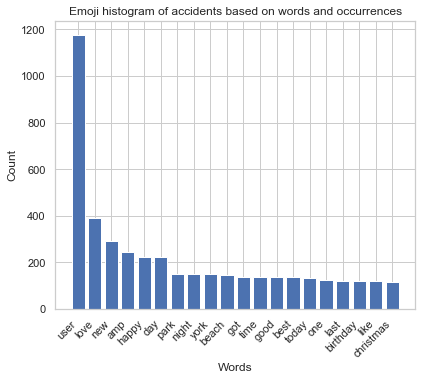

In [38]:
#Here we simply plot the distribution
fig = plt.figure(figsize = (5,4))
axes = fig.add_axes([0,0,1,1])
axes.bar(emoji_top_20_val.keys(),emoji_top_20_val.values())
fig.autofmt_xdate(rotation=45)
axes.set_title('Emoji histogram of accidents based on words and occurrences')
axes.set_ylabel('Count')
axes.set_xlabel('Words');

In [39]:
# Here we multiply the frequency with the rank

In [40]:
li =  []
counter = 1
for elm in emoji_top_20_val.values():
    li.append(elm * counter)
    counter += 1

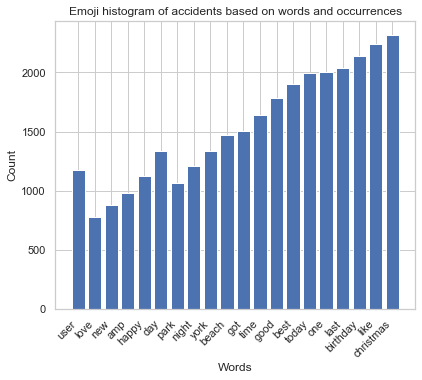

In [41]:
fig = plt.figure(figsize = (5,4))
axes = fig.add_axes([0,0,1,1])
axes.bar(emoji_top_20_val.keys(),li)
fig.autofmt_xdate(rotation=45)
axes.set_title('Emoji histogram of accidents based on words and occurrences')
axes.set_ylabel('Count')
axes.set_xlabel('Words');

In [42]:
# Raw dataset
emoji_raw_val = word_frequency(emoji_words_val_txt)
emoji_raw_train = word_frequency(emoji_words_train_txt)
emoji_raw_test = word_frequency(emoji_words_test_txt)

In [43]:
thing = most_common_words(emoji_raw_val)

In [44]:
li =  []
counter = 1
for elm in thing.values():
    li.append(elm * counter)
    counter += 1
    if counter == 51:
        break

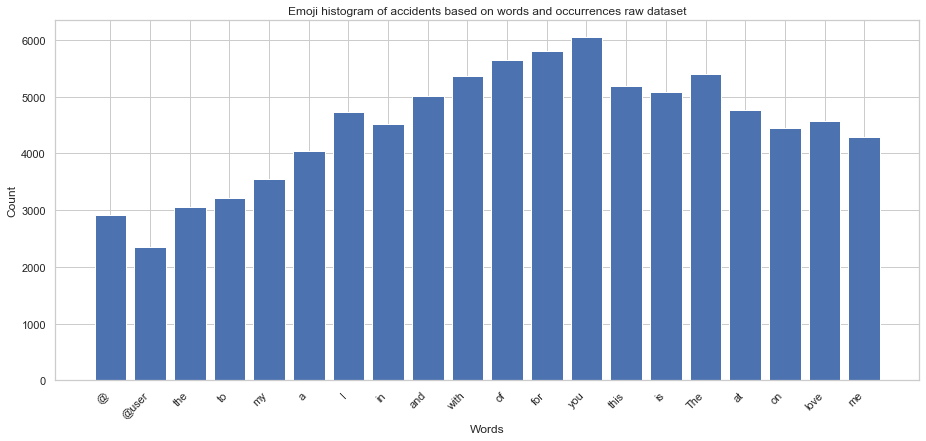

In [45]:
fig = plt.figure(figsize = (12,5))
axes = fig.add_axes([0,0,1,1])
axes.bar(list(thing.keys())[:20],li[:20])
fig.autofmt_xdate(rotation=45)
axes.set_title('Emoji histogram of accidents based on words and occurrences raw dataset')
axes.set_ylabel('Count')
axes.set_xlabel('Words');

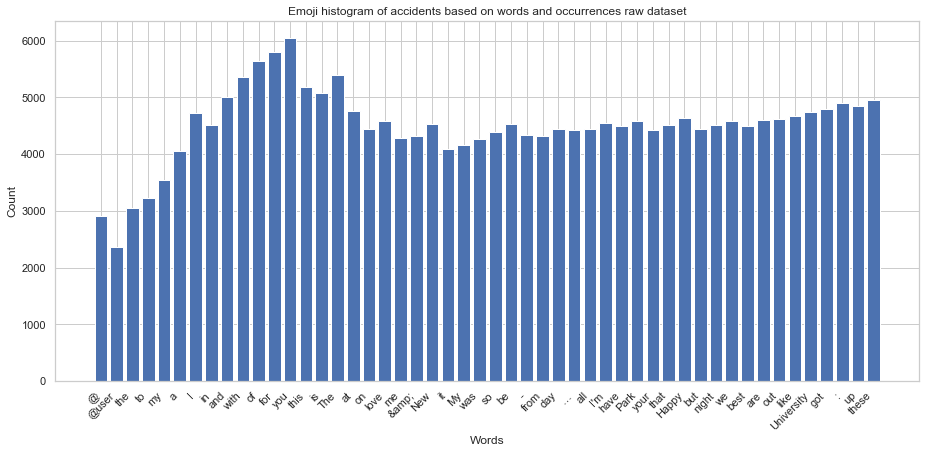

In [46]:
fig = plt.figure(figsize = (12,5))
axes = fig.add_axes([0,0,1,1])
axes.bar(list(thing.keys())[:50],li)
fig.autofmt_xdate(rotation=45)
axes.set_title('Emoji histogram of accidents based on words and occurrences raw dataset')
axes.set_ylabel('Count')
axes.set_xlabel('Words');

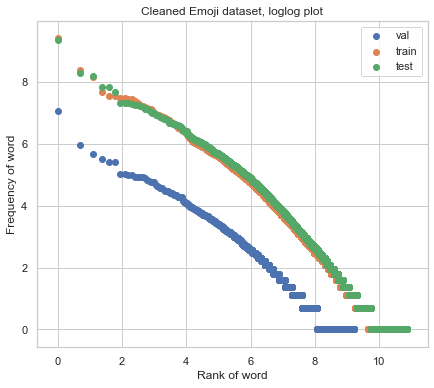

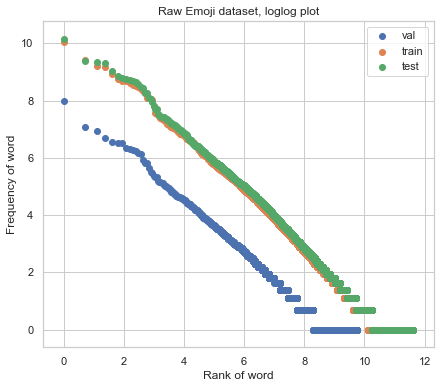

In [47]:
# Cleaned dataset:
llplot([emoji_freq_words_val, emoji_freq_words_train, emoji_freq_words_test], labels=["val", "train", "test"], title="Cleaned Emoji dataset, loglog plot")



llplot([emoji_raw_val, emoji_raw_train, emoji_raw_test], labels=["val", "train", "test"], title="Raw Emoji dataset, loglog plot")

## Type/token ratio

In [48]:
_, tokens, _, _,unique_tokens, _ ,_ = basic_statistics(emoji_text_train,printer = True)

The number of characters: 3285761
The number of tokens is: 671226
The number of sentences is: 23566
The average number of tokens per sentence is: 20
The number of unique tokens are: 45846
The tokens ratio is: 0.068
The number of total tokens after removing stopwords are: 314127


## Offensive dataset

## Size of our offensive vocabulary

In [49]:
print("Number of total words in the vocabulary " + str(len(offensive_freq_words_train)))

Number of total words in the vocabulary 16962


### Top 20 most common tokens 

In [50]:
offensive_top_20_val = top_20_most_common_words(offensive_freq_words_val)
offensive_top_20_train = top_20_most_common_words(offensive_freq_words_train)
offensive_top_20_test = top_20_most_common_words(offensive_freq_words_test)

print('Top 20 in val_text.txt:\n',offensive_top_20_val, '\n')
print('Top 20 in val_train.txt:\n',offensive_top_20_train,'\n')
print('Top 20 in val_test.txt:\n',offensive_top_20_test,'\n')

Top 20 in val_text.txt:
 {'user': 3455, 'liberals': 137, 'gun': 133, 'control': 125, 'antifa': 118, 'like': 109, 'conservatives': 107, 'maga': 98, 'people': 89, 'know': 77, 'get': 73, 'one': 71, 'trump': 69, 'think': 68, 'amp': 62, 'would': 61, 'want': 55, 'us': 52, 'going': 47, 'right': 45} 

Top 20 in val_train.txt:
 {'user': 29961, 'liberals': 1260, 'gun': 1230, 'control': 1095, 'antifa': 1047, 'like': 995, 'maga': 907, 'conservatives': 839, 'people': 830, 'amp': 615, 'get': 586, 'one': 568, 'trump': 565, 'know': 557, 'would': 507, 'think': 483, 'good': 416, 'right': 409, 'time': 349, 'us': 345} 

Top 20 in val_test.txt:
 {'user': 608, 'liberals': 81, 'conservatives': 80, 'antifa': 74, 'like': 65, 'gun': 64, 'control': 64, 'maga': 57, 'get': 51, 'one': 48, 'people': 47, 'trump': 44, 'us': 42, 'love': 38, 'want': 37, 'via': 33, 'know': 31, 'good': 31, 'going': 30, 'new': 30} 



## Top 20 least common tokens

In [51]:
offensive_least_words_val = least_common_words(offensive_freq_words_val)
offensive_least_words_train = least_common_words(offensive_freq_words_train)
offensive_least_words_test = least_common_words(offensive_freq_words_test)
print('Top 20 least common words in offensive_freq_words_val \n',offensive_least_words_val[0:20], '\n')
print('Top 20 least common words in offensive_freq_words_train \n',offensive_least_words_train[0:20], '\n')
print('Top 20 least common words in offensive_freq_words_test \n',offensive_least_words_test[0:20], '\n')

Top 20 least common words in offensive_freq_words_val 
 [('wiiu', 1), ('console', 1), ('az', 1), ('underage', 1), ('lionsden', 1), ('affect', 1), ('hazard', 1), ('club', 1), ('finger', 1), ('aid', 1), ('constituent', 1), ('disclosure', 1), ('etiquette', 1), ('moderation', 1), ('city', 1), ('ft', 1), ('richer', 1), ('sendhim', 1), ('allegation', 1), ('teen', 1)] 

Top 20 least common words in offensive_freq_words_train 
 [('countrymen', 1), ('breitbarters', 1), ('progressing', 1), ('reads', 1), ('unto', 1), ('optic', 1), ('vetsresistsquadron', 1), ('scout', 1), ('lifetimes', 1), ('obummer', 1), ('plethora', 1), ('peruse', 1), ('lighting', 1), ('torches', 1), ('checkmarks', 1), ('verifiedhate', 1), ('lmfaoooooo', 1), ('shitbiscuit', 1), ('tempe', 1), ('licensereporters', 1)] 

Top 20 least common words in offensive_freq_words_test 
 [('ibelieveblaseyford', 1), ('libreal', 1), ('snowflake', 1), ('iran', 1), ('johnkerryiranmeeting', 1), ('angels', 1), ('runs', 1), ('homers', 1), ('connects

## Zipf's Law

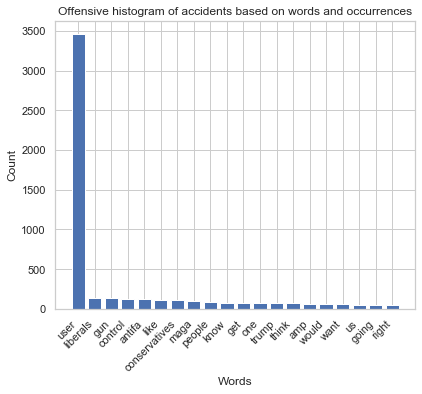

In [52]:
fig = plt.figure(figsize = (5,4))
axes = fig.add_axes([0,0,1,1])
axes.bar(offensive_top_20_val.keys(),offensive_top_20_val.values())
fig.autofmt_xdate(rotation=45)
axes.set_title('Offensive histogram of accidents based on words and occurrences')
axes.set_ylabel('Count')
axes.set_xlabel('Words');

In [53]:
li =  []
counter = 1
for elm in offensive_top_20_val.values():
    li.append(elm * counter)
    counter += 1

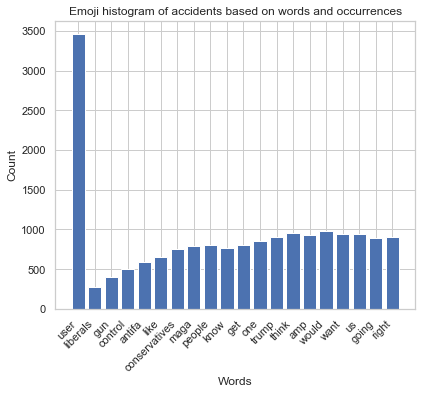

In [54]:
fig = plt.figure(figsize = (5,4))
axes = fig.add_axes([0,0,1,1])
axes.bar(offensive_top_20_val.keys(),li)
fig.autofmt_xdate(rotation=45)
axes.set_title('Emoji histogram of accidents based on words and occurrences')
axes.set_ylabel('Count')
axes.set_xlabel('Words');

In [55]:
# Raw dataset
offensive_raw_val = word_frequency(offensive_words_val_txt)
offensive_raw_train = word_frequency(offensive_words_train_txt)
offensive_raw_test = word_frequency(offensive_words_test_txt)


In [56]:
thing = most_common_words(offensive_raw_val)

In [57]:
li =  []
counter = 1
for elm in thing.values():
    li.append(elm * counter)
    counter += 1
    if counter == 51:
        break

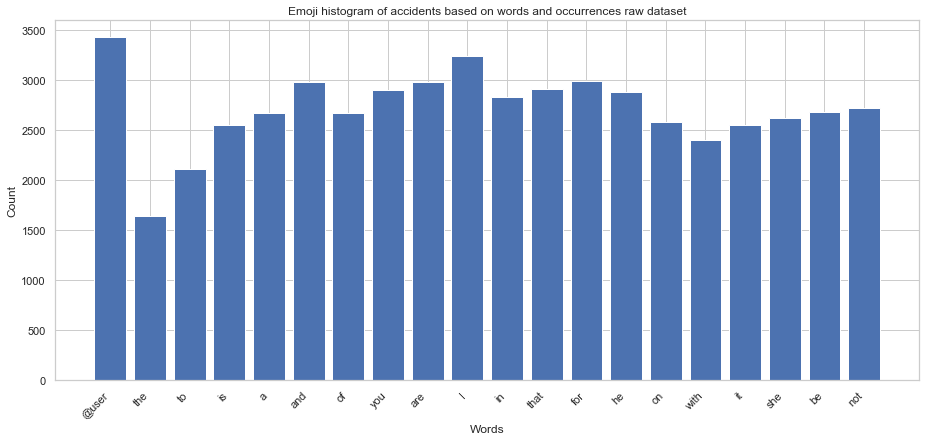

In [58]:
fig = plt.figure(figsize = (12,5))
axes = fig.add_axes([0,0,1,1])
axes.bar(list(thing.keys())[:20],li[:20])
fig.autofmt_xdate(rotation=45)
axes.set_title('Emoji histogram of accidents based on words and occurrences raw dataset')
axes.set_ylabel('Count')
axes.set_xlabel('Words');

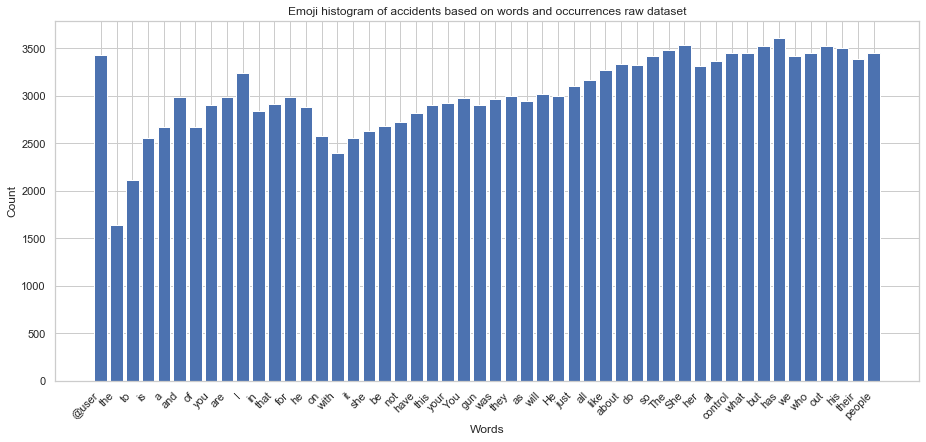

In [59]:
fig = plt.figure(figsize = (12,5))
axes = fig.add_axes([0,0,1,1])
axes.bar(list(thing.keys())[:50],li[:50])
fig.autofmt_xdate(rotation=45)
axes.set_title('Emoji histogram of accidents based on words and occurrences raw dataset')
axes.set_ylabel('Count')
axes.set_xlabel('Words');

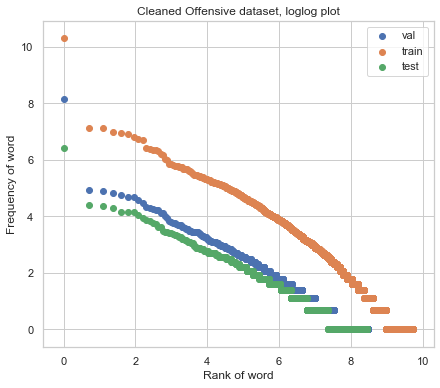

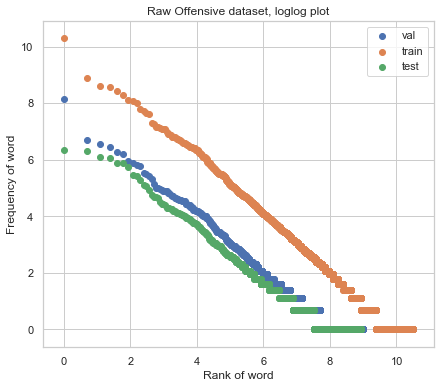

In [60]:
# Cleaned dataset:
llplot([offensive_freq_words_val, offensive_freq_words_train, offensive_freq_words_test], labels=["val", "train", "test"], title="Cleaned Offensive dataset, loglog plot")

llplot([offensive_raw_val, offensive_raw_train, offensive_raw_test], labels=["val", "train", "test"], title="Raw Offensive dataset, loglog plot")

There is an overall trend that the follows the law, however, this is has not been proven mathematicly, and our plots doesn't follow the excact distributions as described.

## Type/token ratio

In [61]:
_, tokens, _, _,unique_tokens, _ ,_ = basic_statistics(offensive_text_train,printer = True)

The number of characters: 1510503
The number of tokens is: 336416
The number of sentences is: 18122
The average number of tokens per sentence is: 14
The number of unique tokens are: 17111
The tokens ratio is: 0.051
The number of total tokens after removing stopwords are: 147302


***

## Data frames for offensive train text and offensive test text

In [62]:


train = pd.read_csv('datasets/offensive/train_text.txt', header=None, skiprows = 0, names=['tweet'], sep='\t', quoting=3)
print("Training Set:"% train.columns, train.shape, len(train))


test = pd.read_csv('datasets/offensive/test_text.txt',header=None, skiprows = 0, names=['tweet'], sep='\t', quoting=3)
print("Test Set:"% test.columns, test.shape, len(test))

Training Set: (11916, 1) 11916
Test Set: (860, 1) 860


In [63]:

index_train = [x for x in range(1, len(train.values)+1)]
index_test = [x for x in range(1, len(test.values)+1)]

train.insert(loc=0, column='id', value =index_train )
test.insert(loc=0, column='id', value =index_test )

train_labels = pd.read_csv('datasets/offensive/train_labels.txt',header=None, skiprows = 0, names=['label'], sep='\t', quoting=3)
train_labels.insert(loc=0, column='id', value=index_train)

test_labels = pd.read_csv('datasets/offensive/test_labels.txt',header=None, skiprows = 0, names=['label'], sep='\t', quoting=3)
test_labels.insert(loc=0, column='id', value =index_test )


test_df = test.merge(test_labels, on='id', how='left')
train_df = train.merge(train_labels, on='id', how='left')




In [64]:
train_df.head()

id                                              tweet  label
0   1  @user Bono... who cares. Soon people will unde...      0
1   2  @user Eight years the republicans denied obama...      1
2   3  @user Get him some line help. He is gonna be j...      0
3   4               @user @user She is great. Hi Fiona!       0
4   5  @user She has become a parody unto herself? Sh...      1

In [65]:
test_df.head()

id                                              tweet  label
0   1  #ibelieveblaseyford is liar she is fat ugly li...      1
1   2  @user @user @user I got in a pretty deep debat...      0
2   3  ...if you want more shootings and more death, ...      0
3   4  Angels now have 6 runs. Five of them have come...      0
4   5  #Travel #Movies and Unix #Fortune combined  Vi...      0

In [66]:
test_clean = clean_text(test_df, 'tweet')
train_clean = clean_text(train_df, 'tweet')

In [67]:
stop = stopwords.words('english')

train_clean['tweet'] = train_clean['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
train_clean.head()

id                                              tweet  label
0   1  bono cares soon people understand gain nothing...      0
1   2  eight years republicans denied obama picks bre...      1
2   3  get line help gonna fine game went could see p...      0
3   4                                     great hi fiona      0
4   5  become parody unto certainly taken heat well i...      1

In [68]:
stop = stopwords.words('english')
test_clean['tweet'] = test_clean['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

test_clean.head()

id                                              tweet  label
0   1  ibelieveblaseyford liar fat ugly libreal snowf...      1
1   2  got pretty deep debate friend told latinos tru...      0
2   3  want shootings death listen aclu black lives m...      0
3   4  angels 6 runs five come courtesy mike trout ho...      0
4   5  travel movies unix fortune combined visit sali...      0

In [69]:
test_clean['tweet'] = test_clean['tweet'].apply(lambda x: word_tokenize(x))
test_clean.head()

id                                              tweet  label
0   1  [ibelieveblaseyford, liar, fat, ugly, libreal,...      1
1   2  [got, pretty, deep, debate, friend, told, lati...      0
2   3  [want, shootings, death, listen, aclu, black, ...      0
3   4  [angels, 6, runs, five, come, courtesy, mike, ...      0
4   5  [travel, movies, unix, fortune, combined, visi...      0

In [70]:

test_clean_offensive = test_clean.loc[test_clean['label'] == 1]
test_clean_offensive.head()
#test_clean_offensive['tweet'].to_csv('test_cleaned_off_lang_df.csv',  quoting=csv.QUOTE_NONE, escapechar=' ') 

id                                              tweet  label
0    1  [ibelieveblaseyford, liar, fat, ugly, libreal,...      1
8    9  [grown, ass, woman, probably, 10, years, older...      1
10  11  [kavanaugh, disciple, anthony, kennedy, ed, li...      1
15  16  [apparently, committed, going, new, level, sin...      1
18  19  [50, cent, calls, joe, budden, bullshit, insta...      1

In [71]:
test_clean_nonoffensive = test_clean.loc[test_clean['label'] == 0]

#test_clean_nonoffensive['tweet'].to_csv('test_cleaned_non_off_lang_df.csv',  quoting=csv.QUOTE_NONE, escapechar=' ') 

test_clean_nonoffensive.head()

id                                              tweet  label
1   2  [got, pretty, deep, debate, friend, told, lati...      0
2   3  [want, shootings, death, listen, aclu, black, ...      0
3   4  [angels, 6, runs, five, come, courtesy, mike, ...      0
4   5  [travel, movies, unix, fortune, combined, visi...      0
5   6  [naturephotography, nature, birds, wild, wisco...      0

In [72]:
test_off_lists = test_clean_offensive['tweet'].values.tolist()
test_off_lists[0]

['ibelieveblaseyford',
 'liar',
 'fat',
 'ugly',
 'libreal',
 'snowflake',
 'sold',
 'get',
 'cash',
 'dems',
 'iran',
 'spoke',
 'johnkerryiranmeeting']

In [73]:
test_non_off_lists = test_clean_nonoffensive['tweet'].values.tolist()
test_non_off_lists[0]

['got',
 'pretty',
 'deep',
 'debate',
 'friend',
 'told',
 'latinos',
 'trump',
 'blacks',
 'trump',
 'paid',
 'supporters',
 'said',
 'mean',
 'antifa',
 'paid',
 'domestic',
 'terrorist',
 'said',
 'anti',
 'fascist',
 'said',
 'fascist',
 'kidding']

# Task 04 - Automatic Prediction

In [74]:
# Merging validation text and labels
val_df = merging_labels_and_sentences('datasets/offensive/val_text', 'datasets/offensive/val_labels')

# Checking for missing values
missing_val = missing_values(val_df)
# Average words devided into labels
avg_labels_word = word_count(val_df)
avg_labels_char = char_count(val_df)

print(' Average Number of Words - Offensive Tweets: ', avg_labels_word[1],'\n','Average Number of Words - Non-offensive Tweets: ', avg_labels_word[2])
print(' Average Characters in Offensive Tweets: ', avg_labels_char[1],'\n','Average Characters in Non-offensive Tweets: ', avg_labels_char[2])

print('\nNumber of missing values for each column\n',missing_val)



 Average Number of Words - Offensive Tweets:  25.569 
 Average Number of Words - Non-offensive Tweets:  22.151
 Average Characters in Offensive Tweets:  143.852 
 Average Characters in Non-offensive Tweets:  126.98

Number of missing values for each column
 id       0
tweet    0
label    0
dtype: int64


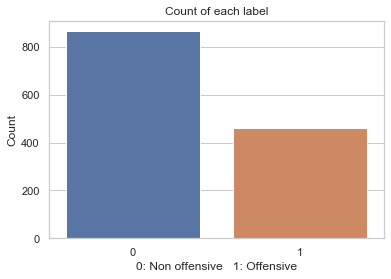

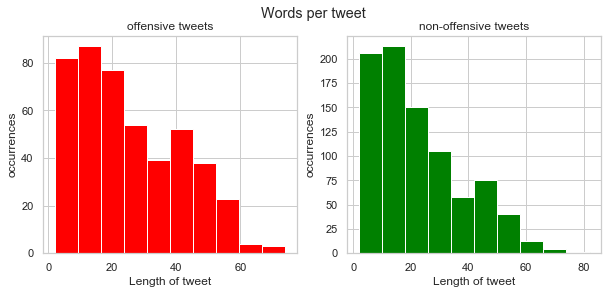

In [75]:
# Number of total labels for each class: 0 = non offensive, 1 = offensive
barplot = class_distribution(val_df,"Count of each label","0: Non offensive   1: Offensive")
# Histogram of Word count pr tweet
plot_word_count = plot_word_count(val_df)

## Term Frequency-Inverse Document Frequencies

Term Frequency-Inverse Document Frequencies (tf-Idf): Count vectors might not be the best representation for converting text data to numerical data. So, instead of simple counting, we can also use an advanced variant of the Bag-of-Words that uses the term frequency–inverse document frequency (or Tf-Idf). Basically, the value of a word increases proportionally to count in the document, but it is inversely proportional to the frequency of the word in the corpus

# We are splitting the data into training and test
X_train, X_test, y_train, y_test = split_dataset_2(val_df,labels)

# Here we tokenize the data
X_train_tok, X_test_tok = tokenize_train_test_2(X_train[:,0].tolist(), X_test[:,0].tolist())

# (tf-Idf)
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train.tolist()) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test.tolist())


val_df['clean_text_tok']=[nltk.word_tokenize(i) for i in val_df['tweet']]
model = gensim.models.Word2Vec(val_df['clean_text_tok'],min_count=1)
w2v = dict(zip(model.wv.index_to_key, model.wv))      
modelw = MeanEmbeddingVectorizer(w2v)

# converting text to numerical data using Word2Vec
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_test_vectors_w2v = modelw.transform(X_test_tok)

In [76]:
# We are splitting the data into training and test
X_train, X_test, y_train, y_test = split_dataset(val_df)

# Here we tokenize the data
X_train_tok, X_test_tok = tokenize_train_test(X_train, X_test)

# (tf-Idf)
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)


val_df['clean_text_tok']=[nltk.word_tokenize(i) for i in val_df['tweet']]
model = gensim.models.Word2Vec(val_df['clean_text_tok'],min_count=1)
w2v = dict(zip(model.wv.index_to_key, model.wv))      
modelw = MeanEmbeddingVectorizer(w2v)

# converting text to numerical data using Word2Vec
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_test_vectors_w2v = modelw.transform(X_test_tok)

## Logistic regression (tf-idf)

In [77]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)

lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')

lr_tfidf.fit(X_train_vectors_tfidf, y_train)  

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.73      0.86      0.79       178
           1       0.55      0.34      0.42        87

    accuracy                           0.69       265
   macro avg       0.64      0.60      0.61       265
weighted avg       0.67      0.69      0.67       265

Confusion Matrix: [[153  25]
 [ 57  30]]
AUC: 0.6751259201859744


C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


In [78]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

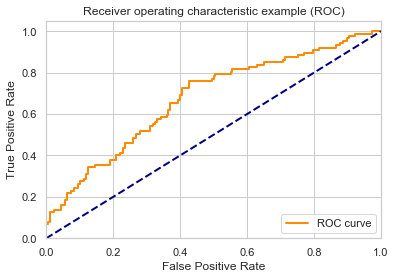

In [79]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example (ROC)')
plt.legend(loc="lower right")
plt.show()

In [80]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)

lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = lr_w2v.predict(X_test_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_test_vectors_w2v)[:,1]

print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.67      0.99      0.80       178
           1       0.50      0.02      0.04        87

    accuracy                           0.67       265
   macro avg       0.59      0.51      0.42       265
weighted avg       0.62      0.67      0.55       265

Confusion Matrix: [[176   2]
 [ 85   2]]
AUC: 0.5979594472426709


C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


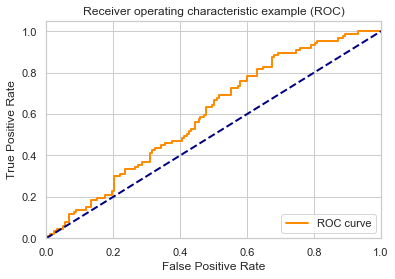

In [81]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example (ROC)')
plt.legend(loc="lower right")
plt.show()

# Naive

# Test

In [82]:

def split_dataset(dataframe):
    X_train, X_test, y_train, y_test = train_test_split(dataframe["tweet"],dataframe      
    ["label"],test_size=0.2,shuffle=True)
    return X_train, X_test, y_train, y_test

def split_dataset_2(dataframe,labels):
    counter = 0
    li = []
    for rows in dataframe.iterrows():
        row = []
        for elm in labels:
            row.append(rows[1][elm])
        li.append(row)
    
    X_train, X_test, y_train, y_test = train_test_split(li,dataframe["label"],test_size=0.2,shuffle=True)
    return X_train,X_test, y_train, y_test
labels = ["tweet","word_count","char_count"]

In [83]:
test = val_df.copy()

In [84]:
test = test.drop(["id"],axis = 1)

In [85]:
test

tweet  label  word_count  \
0         @user @user WiiU is not even a real console.       0           9   
1     @user @user @user If he is from AZ I would put...      1          18   
2     @user I thought Canada had strict gun control....      0          14   
3     @user @user @user @user @user @user @user @use...      0          28   
4             1 Minute of Truth: Gun Control via @user       0           8   
...                                                 ...    ...         ...   
1319  @user @user Whose twitter interest start with ...      0          24   
1320  @user @user How did the press"" get the letter...      0           9   
1321  @user @user @user @user @user @user Sorry abou...      0          52   
1322                         @user Fuck Alan I’m sorry       1           5   
1323  #Tories #Labour #GE2017 #Conservatives Conserv...      0          28   

      char_count                                     clean_text_tok  
0             45  [@, user, @, user, WiiU, is, not, even, a, rea...  
1             83  [@, user, @, user, @, user, If, he, is, from, ...  
2             86  [@, user, I, thought, Canada, had, strict, gun...  
3            173  [@, user, @, user, @, user, @, user, @, user, ...  
4             41  [1, Minute, of, Truth, :, Gun, Control, via, @...  
...          ...                                                ...  
1319         143  [@, user, @, user, Whose, twitter, interest, s...  
1320          59  [@, user, @, user, How, did, the, press, '', '...  
1321         277  [@, user, @, user, @, user, @, user, @, user, ...  
1322          26              [@, user, Fuck, Alan, I, ’, m, sorry]  
1323         235  [#, Tories, #, Labour, #, GE2017, #, Conservat...  

[1324 rows x 5 columns]

In [86]:
li = []
counter = 0
for elm in test["tweet"]:
    li.append(len(re.findall("@user", elm)))

In [87]:
test["Tags"] = li

In [88]:
df_off = test.where(test["label"] == 1).dropna()
df_not_off = test.where(test["label"] == 0).dropna()

In [89]:
df_not_off

tweet  label  word_count  \
0         @user @user WiiU is not even a real console.     0.0         9.0   
2     @user I thought Canada had strict gun control....    0.0        14.0   
3     @user @user @user @user @user @user @user @use...    0.0        28.0   
4             1 Minute of Truth: Gun Control via @user     0.0         8.0   
5     @user @user @user We could help if you are Lon...    0.0        12.0   
...                                                 ...    ...         ...   
1317  @user lmao i really didn’t know him before tha...    0.0        12.0   
1319  @user @user Whose twitter interest start with ...    0.0        24.0   
1320  @user @user How did the press"" get the letter...    0.0         9.0   
1321  @user @user @user @user @user @user Sorry abou...    0.0        52.0   
1323  #Tories #Labour #GE2017 #Conservatives Conserv...    0.0        28.0   

      char_count                                     clean_text_tok  Tags  
0           45.0  [@, user, @, user, WiiU, is, not, even, a, rea...   2.0  
2           86.0  [@, user, I, thought, Canada, had, strict, gun...   1.0  
3          173.0  [@, user, @, user, @, user, @, user, @, user, ...  16.0  
4           41.0  [1, Minute, of, Truth, :, Gun, Control, via, @...   1.0  
5           58.0  [@, user, @, user, @, user, We, could, help, i...   3.0  
...          ...                                                ...   ...  
1317        57.0  [@, user, lmao, i, really, didn, ’, t, know, h...   1.0  
1319       143.0  [@, user, @, user, Whose, twitter, interest, s...   2.0  
1320        59.0  [@, user, @, user, How, did, the, press, '', '...   2.0  
1321       277.0  [@, user, @, user, @, user, @, user, @, user, ...   6.0  
1323       235.0  [#, Tories, #, Labour, #, GE2017, #, Conservat...   0.0  

[865 rows x 6 columns]

In [90]:
Counter(df_off["Tags"])
Counter(df_not_off["Tags"])

Counter({2.0: 193,
         1.0: 393,
         16.0: 4,
         3.0: 79,
         4.0: 38,
         0.0: 87,
         10.0: 1,
         50.0: 11,
         42.0: 1,
         6.0: 12,
         12.0: 3,
         11.0: 6,
         7.0: 5,
         5.0: 17,
         28.0: 1,
         13.0: 1,
         15.0: 1,
         9.0: 3,
         14.0: 3,
         49.0: 3,
         8.0: 1,
         43.0: 2})

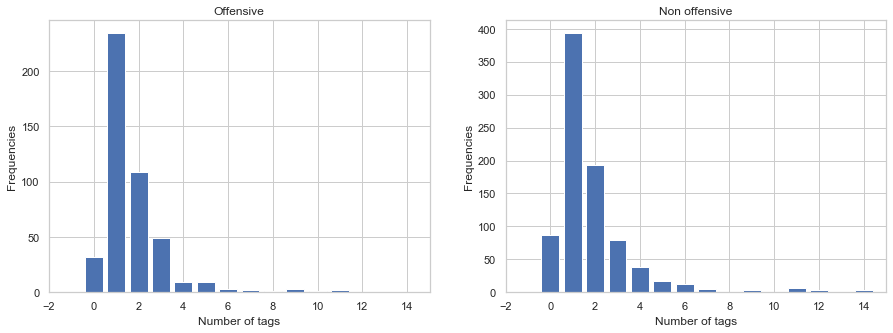

In [91]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
value = Counter(df_off["Tags"]).values()
keys = Counter(df_off["Tags"]).keys()
ax1.bar(keys,value)
ax1.set_ylabel("Frequencies")
ax1.set_xlabel("Number of tags")
ax1.set_title("Offensive")
ax1.set_xlim(-2,15)
value_2 = Counter(df_not_off["Tags"]).values()
keys_2 = Counter(df_not_off["Tags"]).keys()
ax2.bar(keys_2,value_2)
ax2.set_ylabel("Frequencies")
ax2.set_xlabel("Number of tags")
ax2.set_title("Non offensive")
ax2.set_xlim(-2,15)
plt.show()

In [92]:
#featurespace**2

In [93]:
#evt antallet af users

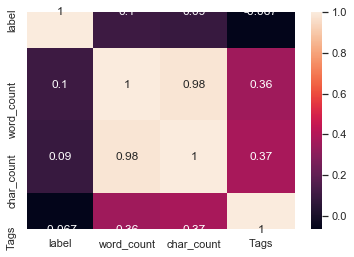

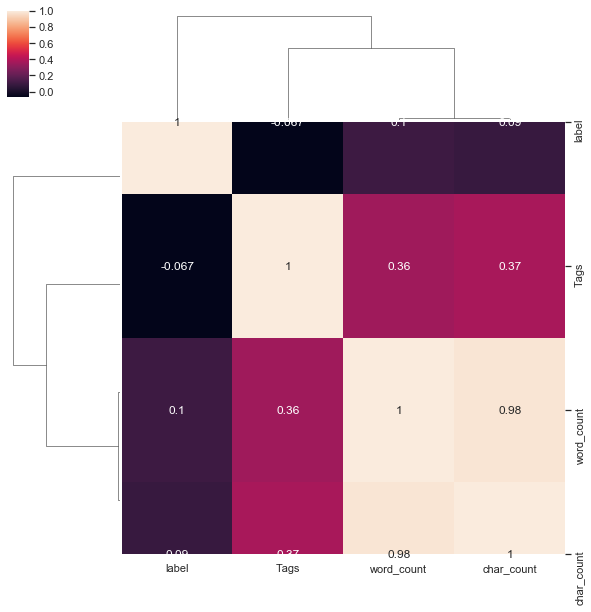

In [94]:
import seaborn as sns

# calculate the correlations
correlations = test.corr()

# plot the heatmap 
sns.heatmap(correlations, xticklabels=correlations.columns, yticklabels=correlations.columns, annot=True)

# plot the clustermap 
sns.clustermap(correlations, xticklabels=correlations.columns, yticklabels=correlations.columns, annot=True)

In [95]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train) 

 #Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.68      0.99      0.81       178
           1       0.80      0.05      0.09        87

    accuracy                           0.68       265
   macro avg       0.74      0.52      0.45       265
weighted avg       0.72      0.68      0.57       265

Confusion Matrix: [[177   1]
 [ 83   4]]
AUC: 0.5984760428774377


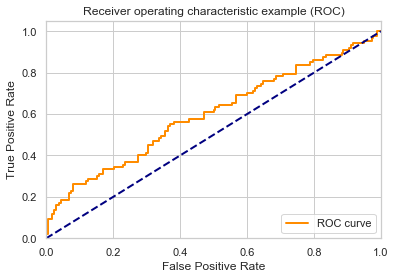

In [96]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example (ROC)')
plt.legend(loc="lower right")
plt.show()

In [97]:
# Sa
model_prediction_preprocessed_data(val_df).to_csv('model_predict_proc_validation.csv')

C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


In [98]:
model_prediction_nonprocessed_data(val_df).to_csv('model_predict_nonproc_validation.csv')

C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)
